# Сборный проект — 2

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

Имеется две задачи:
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании. 

Для этой задачи заказчик предоставил данные с признаками:
- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — показывает, было ли повышение за последний год;
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
- **salary** — ежемесячная зарплата сотрудника;
- **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, **целевой признак**.

# Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from phik import phik_matrix

c:\Users\kapit\Desktop\Разные файлы\Python\Practicum_GIT\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_STATE = 42

In [3]:
pd.set_option('display.max_colwidth', None)

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Шаг 1. Загрузка данных

#### Загрузка данных

In [4]:
train_df = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
test_df = pd.read_csv('datasets/test_features.csv')
test_target_df = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [6]:
train_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [8]:
test_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [9]:
test_target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [10]:
test_target_df.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


#### Вывод

Были получены 3 таблицы, тип данных указан верно, имена признаков соответствуют snake_case, требуется устранение пропусков и проверка на дубликаты.

### Шаг 2. Предобработка данных

In [11]:
# Функция для показа уникальных объектов во всех признаках типа данных object, для помощи в поиске неявных дубликатов и пропусков
def unique_objects(df, value='id'):
    for col in df:
        if df[col].dtypes == 'object':
            print(df.groupby(by=col)[value].count())
            print('___________________________')

#### Обработка пропусков

In [12]:
unique_objects(train_df)

dept
hr             456
marketing      550
purchasing     610
sales         1512
technology     866
Name: id, dtype: int64
___________________________
level
junior    1894
middle    1744
sinior     358
Name: id, dtype: int64
___________________________
workload
high       734
low       1200
medium    2066
Name: id, dtype: int64
___________________________
last_year_promo
no     3880
yes     120
Name: id, dtype: int64
___________________________
last_year_violations
no     3441
yes     559
Name: id, dtype: int64
___________________________


In [13]:
unique_objects(test_df)

dept
                1
hr            227
marketing     279
purchasing    273
sales         763
technology    455
Name: id, dtype: int64
___________________________
level
junior    974
middle    854
sinior    171
Name: id, dtype: int64
___________________________
workload
             1
high       363
low        593
medium    1043
Name: id, dtype: int64
___________________________
last_year_promo
no     1937
yes      63
Name: id, dtype: int64
___________________________
last_year_violations
no     1738
yes     262
Name: id, dtype: int64
___________________________


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


В датасете *test_df* найдены неявные пропуски у признаков "dept" и "workload", заполненные пробелами. Пропусков в train_df и test_df не много, можно замнить их на значение моды с помощью пайплайна и SimpleImputer:

In [15]:
nan_col = ['dept', 'level', 'workload']

In [16]:
pipe_nan = Pipeline([
    ('nan_imputer', SimpleImputer(strategy='most_frequent')),
    ('space_imputer', SimpleImputer(missing_values=' ', strategy='most_frequent'))
])

In [17]:
train_df[nan_col] = pipe_nan.fit_transform(train_df[nan_col])
test_df[nan_col] = pipe_nan.transform(test_df[nan_col])

In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   4000 non-null   object 
 2   level                  4000 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [19]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   2000 non-null   object
 2   level                  2000 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


Пропуски в датасетах *train_df* и *test_df* в признаках "level" и "dept", заменены на значение моды этих признаков. 

#### Обработка дубликатов

In [20]:
train_df.duplicated().sum()

np.int64(0)

In [21]:
test_df.duplicated().sum()

np.int64(0)

In [22]:
test_target_df.duplicated().sum()

np.int64(0)

Дубликаты не обнаружены.

#### Вывод

В ходе предобработки данных были устранены пропуски в признаках "dept" и "level" в датасетах *train_df* и *test_df*, с использованием SimpleImputer, на значения моды. Также проведена проверка на дубликаты, дубликаты не обнаружены.

### Шаг 3. Исследовательский анализ данных

In [23]:
# Функция для построения графиков hist и boxplot для количественных и bar для категориальных признаков

def my_plot(df, 
            col, 
            values='id', 
            aggfunc='count', 
            barh=False, 
            bins=20, 
            sort=False, 
            ascending=True,
            boxplot=True,
            describe=True,
            title=None,
            label='Кол-во'
           ):
    if title == None:
        title = col.replace('_', ' ').capitalize()
    
    if df[col].dtypes != 'object':
        plt.figure(figsize=(10,6), dpi= 80)
        df[col].plot(
            kind='hist', 
            bins=bins, 
            title=title, 
            figsize=(10, 6),
            color=sns.color_palette("viridis")[2:5]
        )
        plt.title(title,  fontdict = {'fontsize': 15})
        plt.show()
        if boxplot == True:
            plt.figure(figsize=(10,6), dpi= 80)
            df.boxplot(
                column=[col],
                figsize=(10, 6)
            )
            plt.title(title,  fontdict = {'fontsize': 15})
            plt.show()
        if describe == True:
            display(df[col].describe())
    else:
        res = df.pivot_table(
            index=col, 
            values=values, 
            aggfunc=aggfunc
        )
        if sort == True:
            res = res.sort_values(by=values, ascending=ascending) 
            
        plt.figure(figsize=(10,6), dpi= 80)
        if barh == False:
            sns.barplot(x=[*res.index], y=values, data=res, palette="viridis")
            plt.xlabel(title)
            plt.ylabel(label)
        elif barh == True:
            sns.barplot(x=values, y=[*res.index], data=res, palette="viridis")
            plt.xlabel(label)
            plt.ylabel(title)
        plt.title(title,  fontdict = {'fontsize': 15})

        plt.show()

In [24]:
# Функция для постраения круговой диаграммы
def my_pie_plot(df, col, values='id', aggfunc='count', title=None, legend=False, figsize=(10, 10), show_data=False):
    if title == None:
        title = col.replace('_', ' ').capitalize()
        
    res = df.pivot_table(
        index=col, 
        values=values, 
        aggfunc=aggfunc)
    res.plot(
        kind='pie', 
        autopct='%1.0f%%', 
        subplots=True,
        figsize=figsize,
        colors=sns.color_palette('viridis')[2:5],
        textprops={'fontsize':14},
        legend=legend)
    
    plt.title(title,  fontdict = {'fontsize' : 15})
    plt.show()
    if show_data == True:
        return display(res.sort_values(by=values, ascending=False))

#### Исследовательский анализ  train_df и test_df

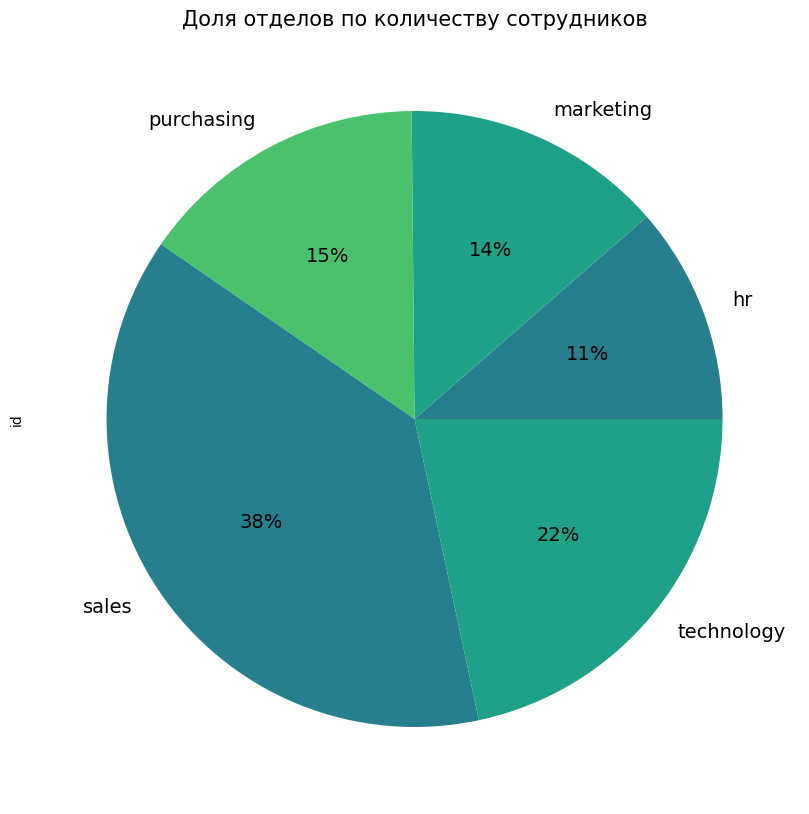

In [25]:
my_pie_plot(train_df, 'dept', title='Доля отделов по количеству сотрудников')

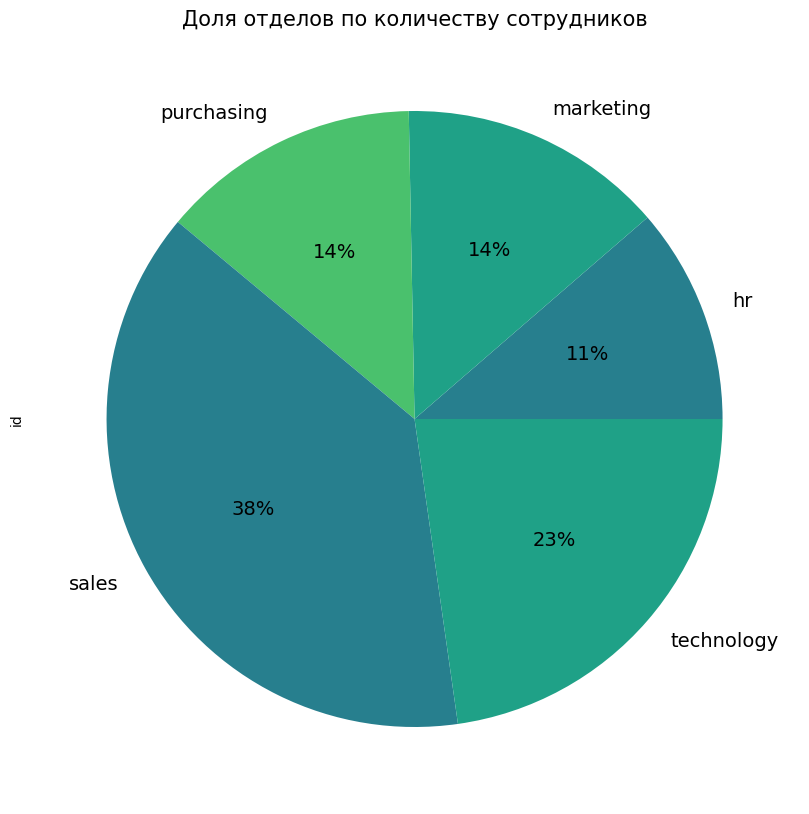

In [26]:
my_pie_plot(test_df, 'dept', title='Доля отделов по количеству сотрудников')

Соотношение долей в тестовой и тренировочной выборках схоже. Большая часть работников работает в отделе продаж - 38%.

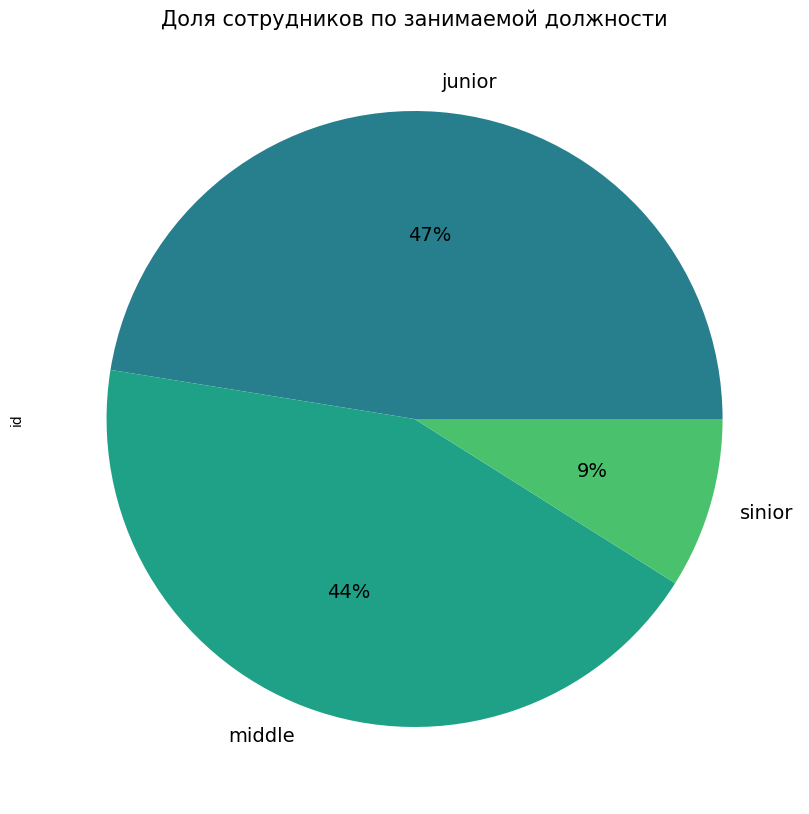

In [27]:
my_pie_plot(train_df, 'level', title='Доля сотрудников по занимаемой должности')

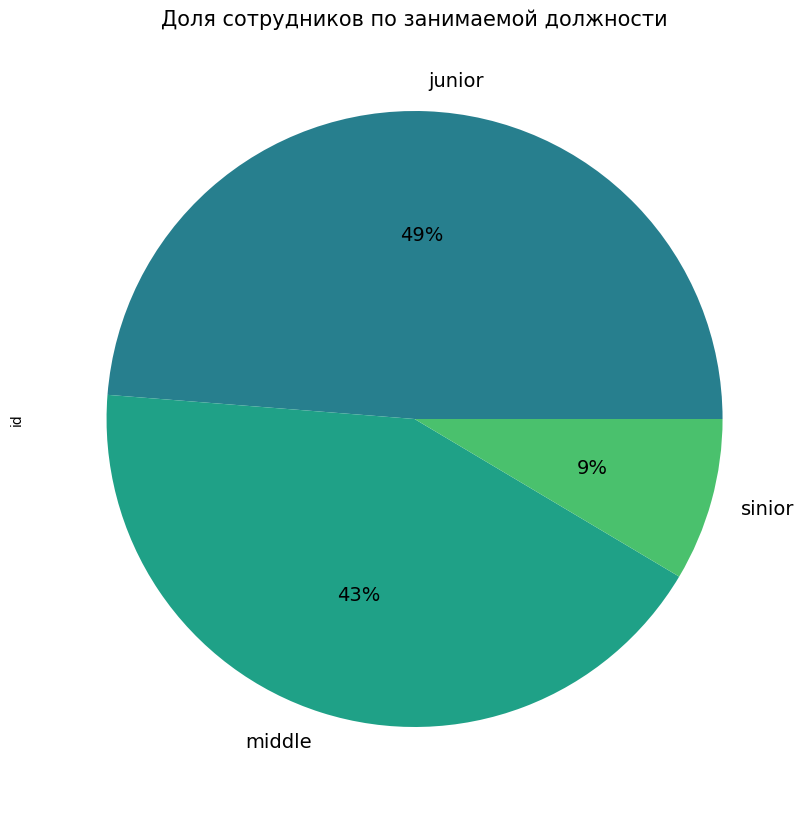

In [28]:
my_pie_plot(test_df, 'level', title='Доля сотрудников по занимаемой должности')

Соотношение долей в тестовой и тренировочной выборках схоже. На первом месте идут джуниоры 47-49%, на втором мидл 43-44%, меньше всего синьоров - 9%.

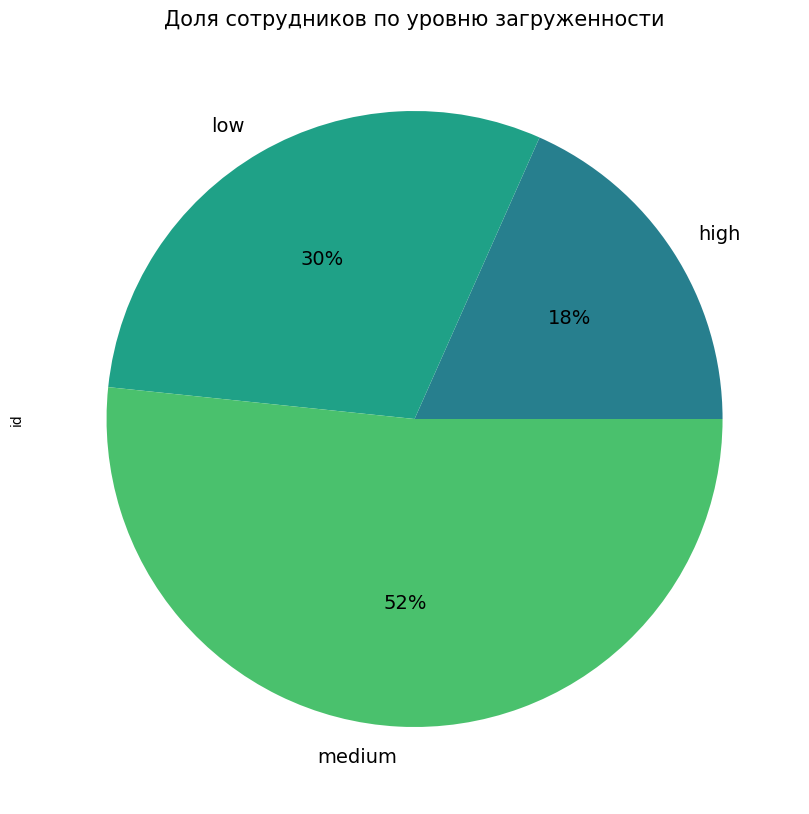

In [29]:
my_pie_plot(train_df, 'workload', title='Доля сотрудников по уровню загруженности')

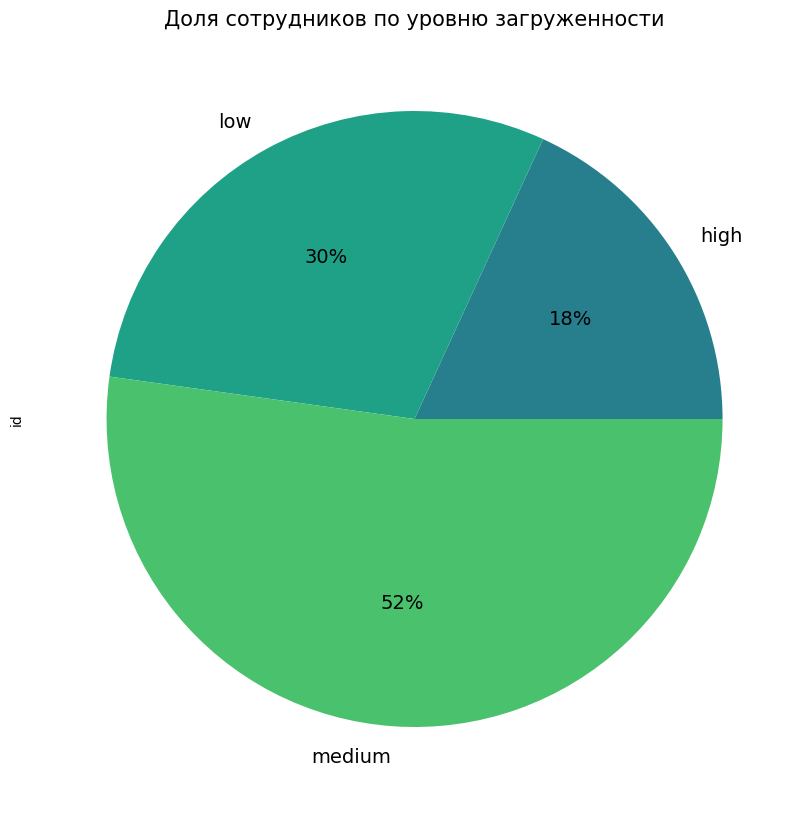

In [30]:
my_pie_plot(test_df, 'workload', title='Доля сотрудников по уровню загруженности')

Соотношение долей в тестовой и тренировочной выборках идентично. Больше половины сотрудников, 52%, имеют средний уровень загруженности, 30% загружены слабо и 18% высоко.

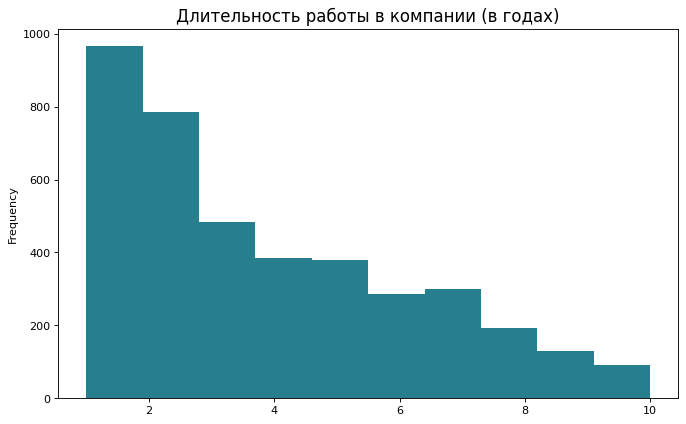

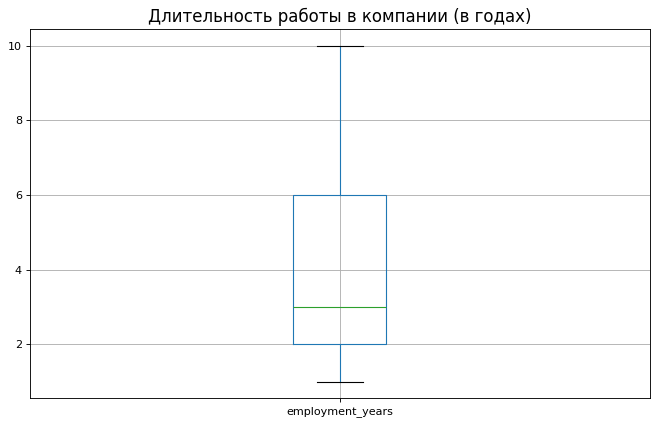

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [31]:
my_plot(train_df, 'employment_years', bins=10, title='Длительность работы в компании (в годах)')

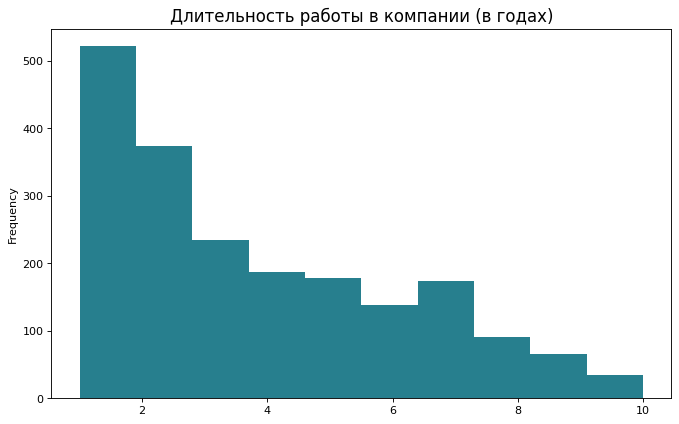

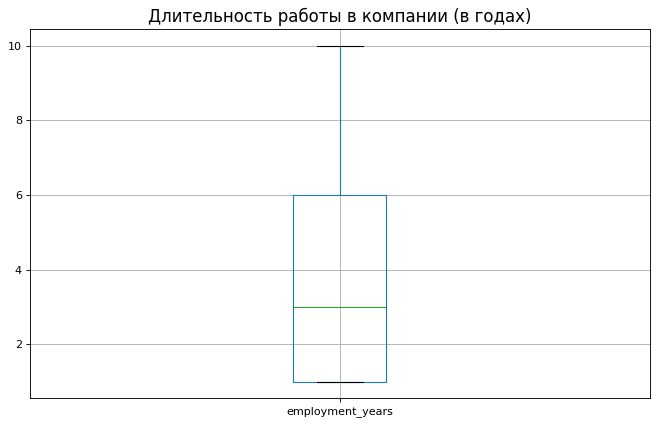

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [32]:
my_plot(test_df, 'employment_years', bins=10, title='Длительность работы в компании (в годах)')

Данные в тестовой и тренировочной выборках распределены похоже. Почти половина сотрудников работают в компании не больше двух лет, средний срок работы в компании около 3,5 лет.

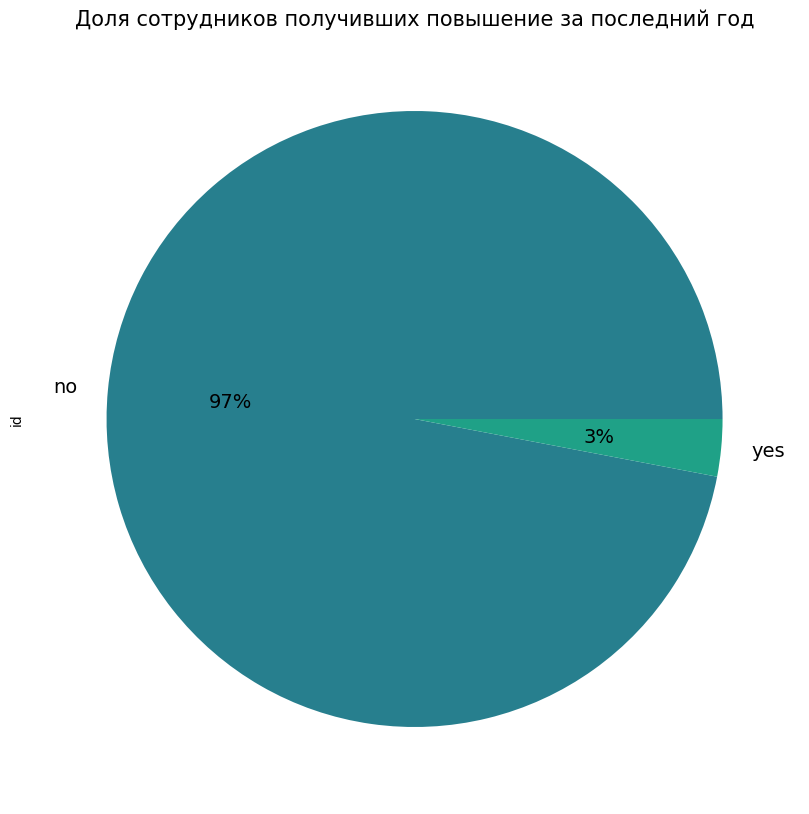

In [33]:
my_pie_plot(train_df, 'last_year_promo', title='Доля сотрудников получивших повышение за последний год')

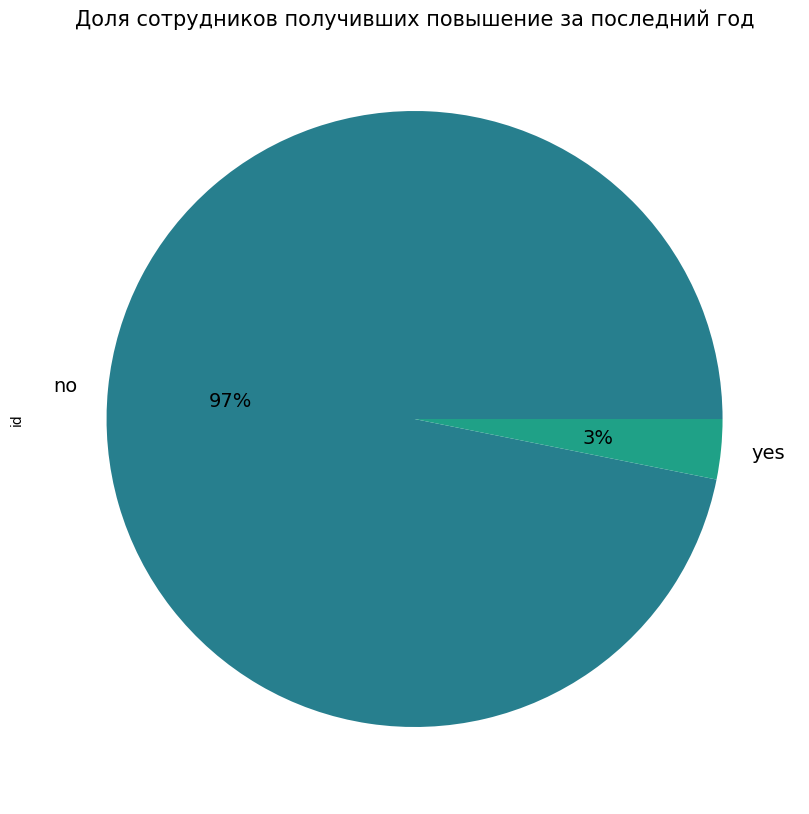

In [34]:
my_pie_plot(test_df, 'last_year_promo', title='Доля сотрудников получивших повышение за последний год')

Соотношение долей в тестовой и тренировочной выборках идентично. 3% сотрудников получили повышение за последний год.

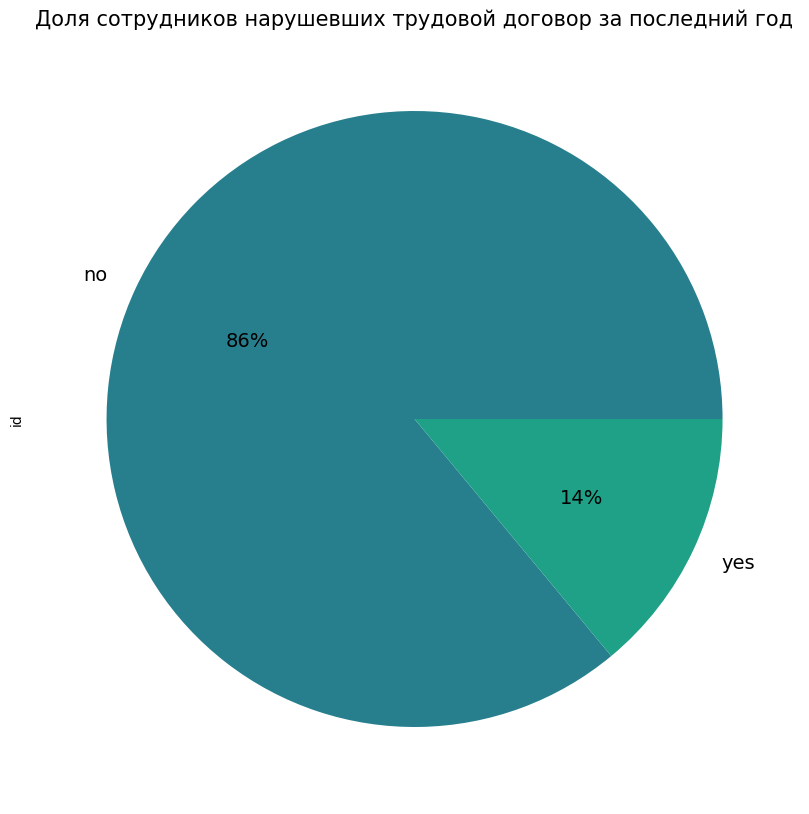

In [35]:
my_pie_plot(train_df, 'last_year_violations', title='Доля сотрудников нарушевших трудовой договор за последний год')

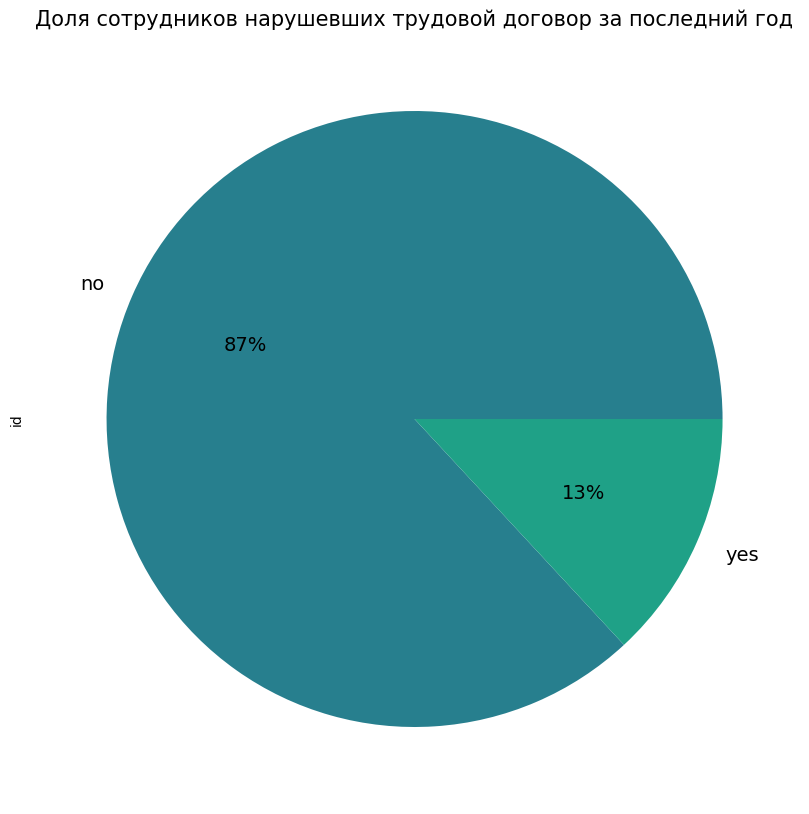

In [36]:
my_pie_plot(test_df, 'last_year_violations', title='Доля сотрудников нарушевших трудовой договор за последний год')

Соотношение долей в тестовой и тренировочной выборках схоже. 13-14% сотрудников нарушили трудовой договор за последний год.

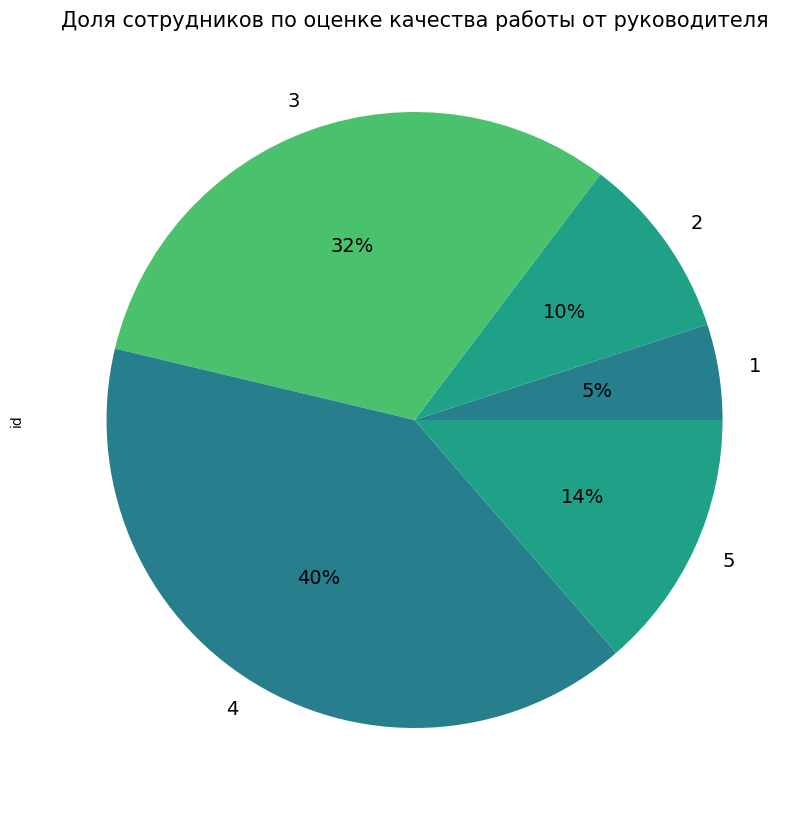

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [37]:
my_pie_plot(train_df, 'supervisor_evaluation', title='Доля сотрудников по оценке качества работы от руководителя')
train_df['supervisor_evaluation'].describe()

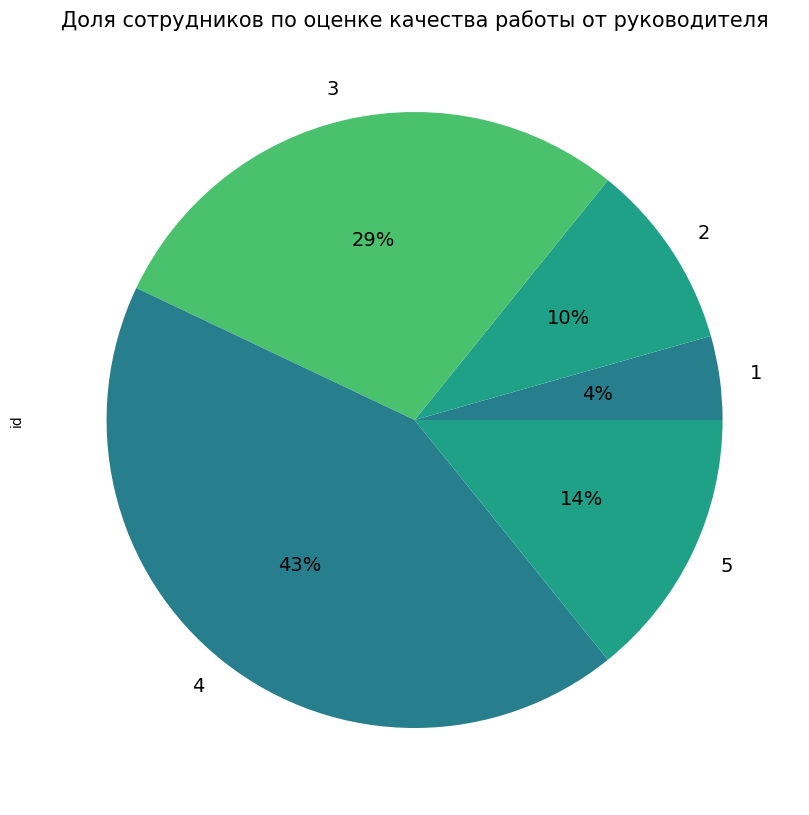

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [38]:
my_pie_plot(test_df, 'supervisor_evaluation', title='Доля сотрудников по оценке качества работы от руководителя')
test_df['supervisor_evaluation'].describe()

Соотношение долей в тестовой и тренировочной выборках схоже. Большенство сотрудников имеют оценку 4 - 40-43%. Средняя оценка по компании 3,5.

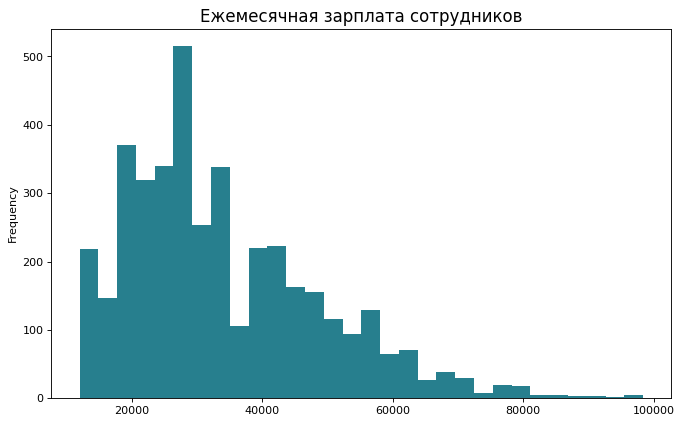

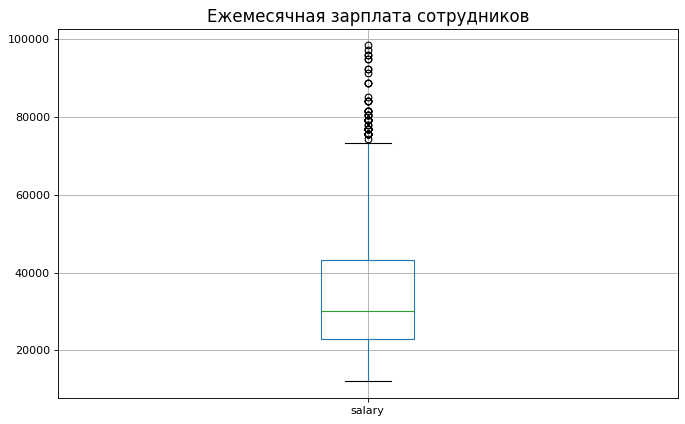

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

In [39]:
my_plot(train_df, 'salary', bins=30, title='Ежемесячная зарплата сотрудников')

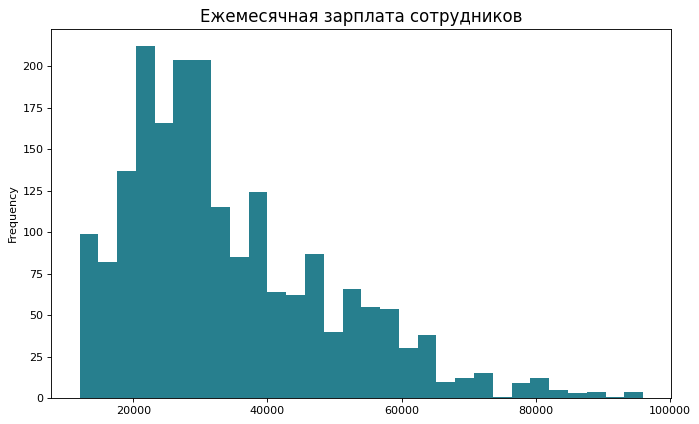

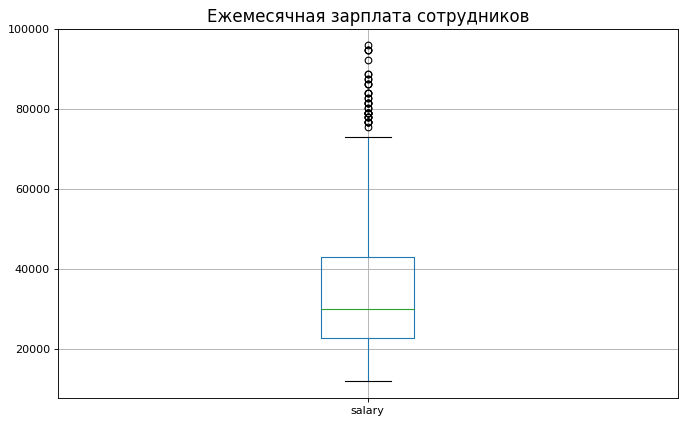

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [40]:
my_plot(test_df, 'salary', bins=30, title='Ежемесячная зарплата сотрудников')

Распределение в тестовой и тренировочной выборках схоже. Основной пик в зарплате находится в районе 30 тыс руб. Медианная зарплата в компании - 30 тысяч рублей, наблюдаются выбросы от 70 до 100 тысяч, стандартное отклонение около 15 тысяч рублей.

#### Исследовательский анализ целевых признаков

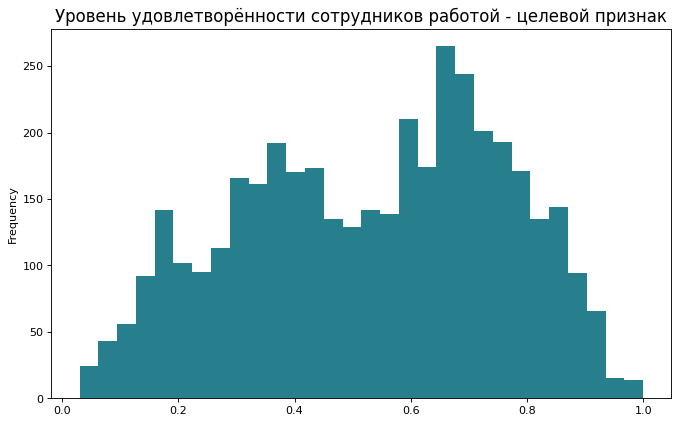

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [41]:
my_plot(
    train_df, 
    'job_satisfaction_rate', 
    bins=30, boxplot=False, 
    title='Уровень удовлетворённости сотрудников работой - целевой признак'
    )

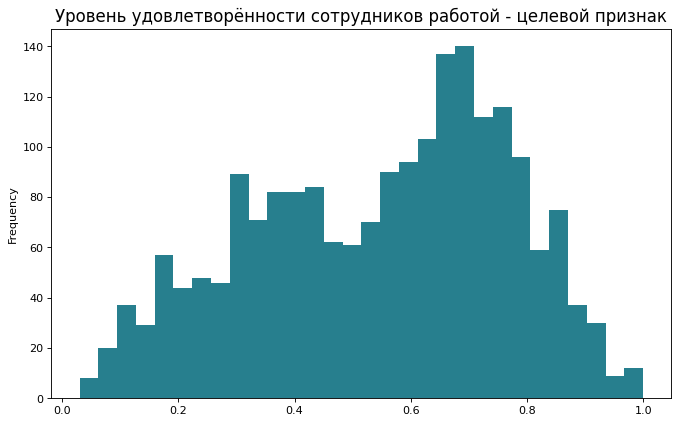

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [42]:
my_plot(
    test_target_df, 
    'job_satisfaction_rate', 
    bins=30, boxplot=False, 
    title='Уровень удовлетворённости сотрудников работой - целевой признак'
    )

Распределение целевого признака в *train_df* и *test_target_df* схоже. В распределенях наблюдается пик в районе 0,7. Средняя удовлетворенность сотрудников равна 53-54%, минимальная удовлетворенность 3%, максимальная 100%.

#### Корреляционный анализ

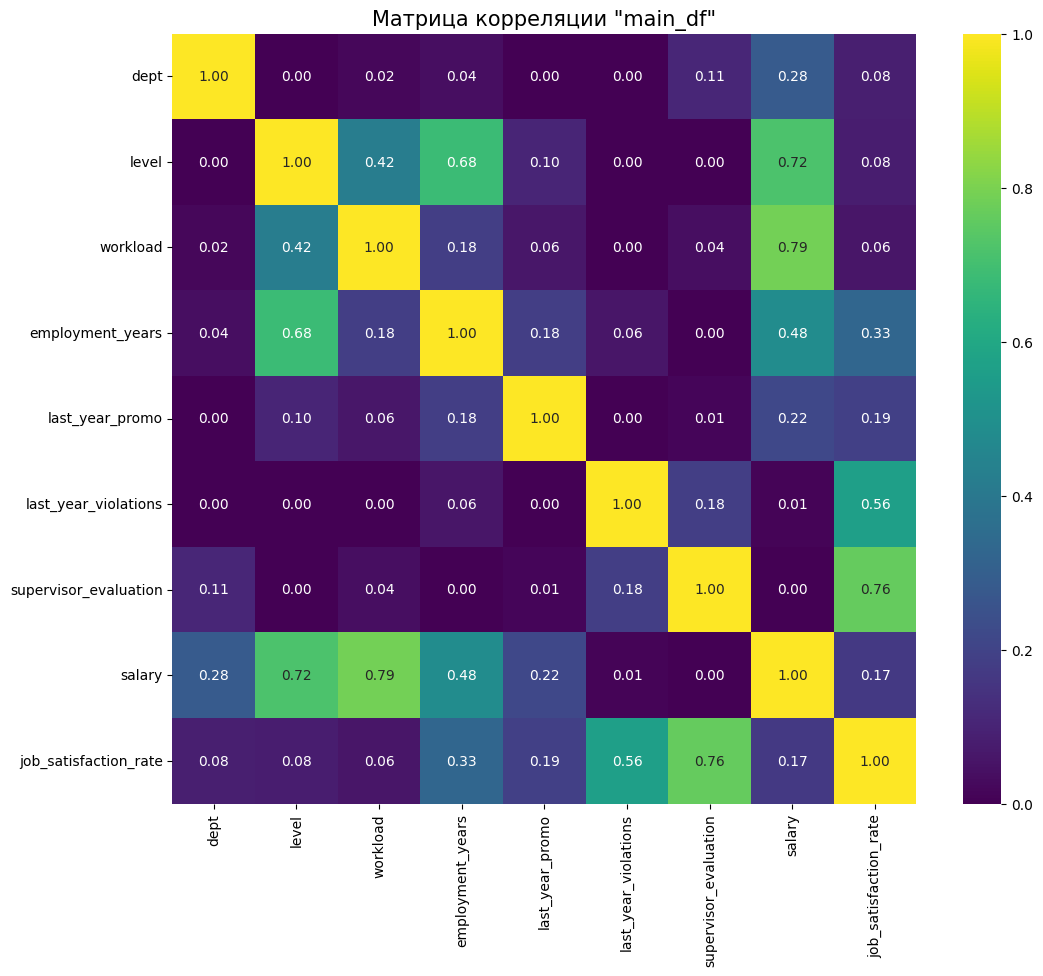

In [43]:
plt.figure(figsize=(12,10), dpi= 100)
sns.heatmap(train_df.drop('id', axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot = True, fmt=".2f", cmap='viridis')
plt.title('Матрица корреляции "main_df"',  fontdict = {'fontsize' : 15})
plt.show()

Мультиколениарность признаков не наблюдается. Целевой признак "job_satisfaction_rate" сильнее всего коррелирует с признаком "supervisor_evaluation" - 0,76, так же заметно коррелирует с "last_year_violations" - 0,56 и умеренно с "employment_years" - 0,33, самая слабая корреляция, не выше 0,10, с "dept", "level" и "workload".

#### Вывод

Самый большой отдел по количеству работников - отдел продаж, там работают 38% сотрудников компании. По занимаемым должностям на первом месте идут джуниоры 47-49%, на втором мидлы 43-44%, на третьем синьоры - 9%. 52% сотрудников имеют средний уровень загруженности, 30% загружены слабо и 18% высоко. Почти половина сотрудников работают в компании не больее двух лет, средний срок работы в компании около 3,5 лет. За последний год 3% сотрудников получили повышение и 13-14% сотрудников нарушили трудовой договор. Большенство сотрудников имеют оценку своей работы от руководителя - 4 (40-43%). Средняя оценка по компании - 3,5. Медианная зарплата в компании - 30 тысяч рублей. Средняя удовлетворенность сотрудников равна 53-54%, минимальная удовлетворенность 3%, максимальная 100%. Целевой признак сильнее всего коррелирует с признаками "supervisor_evaluation", "last_year_violations" и "employment_years". Слабее всего с "dept", "level" и "workload".

Между данными train_df и test_target_df соблюдена стратификация.

### Шаг 4. Подготовка данных

Заменим индексы на значение признака "id" и отсортируем данные по индексу:

In [44]:
train_df = train_df.set_index('id').sort_values(by='id')
test_df = test_df.set_index('id').sort_values(by='id')
test_target_df = test_target_df.set_index('id').sort_values(by='id')

Проверим на новые явные дубликаты после исключения признака "id":

In [45]:
train_df.duplicated().sum()

np.int64(248)

Удалим дубликаты:

In [46]:
train_df.shape

(4000, 9)

In [47]:
train_df.drop_duplicates(keep='first', inplace=True)

In [48]:
train_df.shape

(3752, 9)

Разделим датасеты на учебные и тренировочные выборки и применим кодирование:

### Шаг 5. Обучение моделей

#### Создание метрики "SMAPE"

In [49]:
def smape(y_true, y_pred):
    n = len(y_true)
    summ = 0
    for yt, yp in zip(y_true, y_pred):
        summ += abs(yt-yp) / ((abs(yt)+abs(yp))/2)
    return 100/n * summ

In [50]:
smape_score = make_scorer(smape, greater_is_better=False)

#### Поиск и обучение лучшей модели

Создадим пайплайн для поиска лучшей модели:

In [51]:
# Функция для бининга salary 
def bin_salary(x):
    if x <= 25000:
        return 0
    elif 25000 < x >= 50000:
        return 1
    else:
        return 2

In [52]:
# Формирование тренировочной тестовой выборки 
X_train = train_df.drop('job_satisfaction_rate', axis=1)
y_train = train_df['job_satisfaction_rate']

X_test = test_df.copy(deep=True)
y_test = test_target_df['job_satisfaction_rate']

# Бининг salary и создание нового признака salary_bin
X_train['salary_bin'] = X_train['salary'].apply(bin_salary)
X_test['salary_bin'] = X_test['salary'].apply(bin_salary)

# списки с названиями признаков
ohe_col = ['dept']
ord_col = ['level', 'workload', 'last_year_promo', 'last_year_violations']
num_col = ['salary']

# Пайплайн для OneHotEncoder кодирования
ohe_pipe = Pipeline([
    ('ohe_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Пайплайн для OrdinalEncoder кодирования
ord_pipe = Pipeline([
    ('ord_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

# Общий пайплайн для кодирования всех признаков
data_prerocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_col),
    ('ord', ord_pipe, ord_col),
    ('num', StandardScaler(), num_col)
],
    remainder='passthrough'
)

# Финальный пайплайн для первой модели 
pipe_first_model = Pipeline([
    ('prerocessor', data_prerocessor),
    ('models', LinearRegression())
])

param_grid = [
    {
        'models': [LinearRegression()]
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'models__min_samples_split': range(5, 10),
        'models__min_samples_leaf': range(1, 5)
    }
]

grid_search = GridSearchCV(
    pipe_first_model,
    param_grid,
    scoring=smape_score,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print('Лучшая модель:', grid_search.best_estimator_)
print('Метрика лучшей модели на тренировочных данных:', grid_search.best_score_)

Лучшая модель: Pipeline(steps=[('prerocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord_encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan))]),
                                                  ['level', 'workload',
                                                   'la

In [53]:
result = pd.DataFrame(grid_search.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
1914,1,DecisionTreeRegressor(random_state=42),-15.246187,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'models__max_features': 10, 'models__min_samples_leaf': 3, 'models__min_samples_split': 8}"
1930,2,DecisionTreeRegressor(random_state=42),-15.264722,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'models__max_features': 11, 'models__min_samples_leaf': 2, 'models__min_samples_split': 9}"
1908,3,DecisionTreeRegressor(random_state=42),-15.270432,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'models__max_features': 10, 'models__min_samples_leaf': 2, 'models__min_samples_split': 7}"
1916,4,DecisionTreeRegressor(random_state=42),-15.314094,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'models__max_features': 10, 'models__min_samples_leaf': 4, 'models__min_samples_split': 5}"
1917,4,DecisionTreeRegressor(random_state=42),-15.314094,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 14, 'models__max_features': 10, 'models__min_samples_leaf': 4, 'models__min_samples_split': 6}"
...,...,...,...,...
4,1997,DecisionTreeRegressor(random_state=42),-22.231563,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 5, 'models__min_samples_leaf': 1, 'models__min_samples_split': 8}"
2,1998,DecisionTreeRegressor(random_state=42),-22.301104,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 5, 'models__min_samples_leaf': 1, 'models__min_samples_split': 6}"
3,1999,DecisionTreeRegressor(random_state=42),-22.362414,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 5, 'models__min_samples_leaf': 1, 'models__min_samples_split': 7}"
1,2000,DecisionTreeRegressor(random_state=42),-22.372070,"{'models': DecisionTreeRegressor(random_state=42), 'models__max_depth': 5, 'models__max_features': 5, 'models__min_samples_leaf': 1, 'models__min_samples_split': 5}"


Применим модель к тестовым данным:

In [54]:
jsr_model = grid_search.best_estimator_
y_pred = jsr_model.predict(X_test)

Высчитаем метрику SMAPE на тестовых данных:

Критерий усеха:  метрика SMAPE меньше 15.

In [55]:
print(f'Метрика равна:', smape(y_test, y_pred).round(2))

Метрика равна: 13.35


Метрика на тестовых данных ниже 15, значит модель справилась хорошо.

### Шаг 6. Оформление выводов

Была создана метрика SMAPE - симметричное среднее абсолютное процентное отклонение. Метрика была применена для оценки модели  при кросс-валидации. В ходе подбра моделей и их гипер параметров, между моделями LinearRegression и DecisionTreeRegressor, была выбрана модель **DecisionTreeRegressor(max_depth=14, max_features=10, min_samples_leaf=3, min_samples_split=8, random_state=42)**. Метрика модели SMAPE на тестовых данных составила меньше **13,35**, что является хорошим показателем. 


In [56]:
X_train_shap = pd.DataFrame(
    data_prerocessor.fit_transform(X_train),
    columns=data_prerocessor.get_feature_names_out()
)
explainer = shap.Explainer(grid_search.best_estimator_.named_steps['models'], X_train_shap)
shap_values = explainer(X_train_shap)

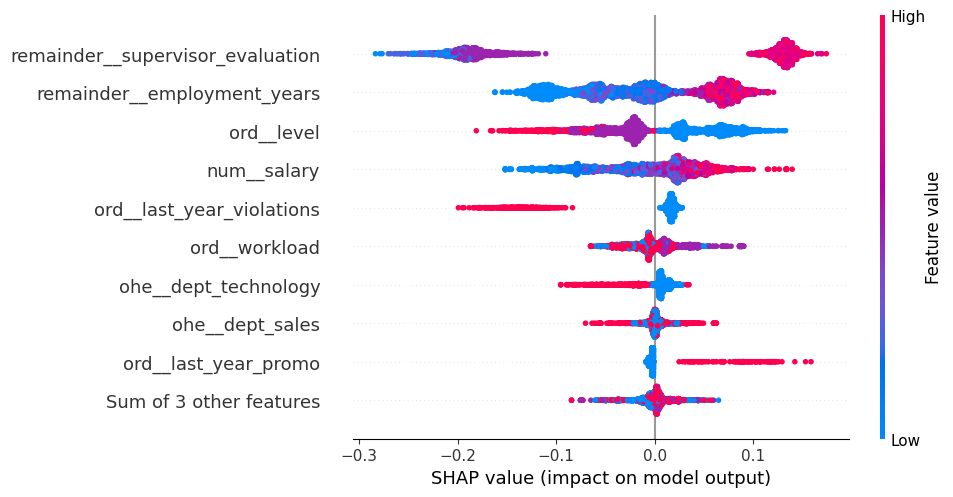

In [57]:
shap.plots.beeswarm(shap_values)

Самым значимым признаком в моделе оказалась оценка руководства, чем выше оценка руководства - тем выше удовлетворенность сотрудника своей работой, на втором месте по значимости идет длительность работы в компании, чем больше человек работает тем выше его удовлетворенность работой в компании. Третий по значимости признак - занимаемая должность, чем она выше тем удовлетваренность ниже. На четвертом месте зарплата, с ее увеличением растет и удовлетворенность.

## Задача 2: предсказание увольнения сотрудника из компании

### Шаг 1. Загрузка данных

#### Загрузка данных

In [58]:
train_quit_df = pd.read_csv('datasets/train_quit.csv')
test_target_quit_df = pd.read_csv('datasets/test_target_quit.csv')

In [59]:
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [60]:
train_quit_df.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [61]:
test_target_quit_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [62]:
test_target_quit_df.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


#### Вывод

Названия признаков и типы данных корректны, пропусков нет.

### Шаг 2. Предобработка данных

#### Обработка пропусков

In [63]:
unique_objects(train_quit_df)

dept
hr             464
marketing      582
purchasing     588
sales         1438
technology     928
Name: id, dtype: int64
___________________________
level
junior    1949
middle    1694
sinior     357
Name: id, dtype: int64
___________________________
workload
high       674
low       1208
medium    2118
Name: id, dtype: int64
___________________________
last_year_promo
no     3887
yes     113
Name: id, dtype: int64
___________________________
last_year_violations
no     3455
yes     545
Name: id, dtype: int64
___________________________
quit
no     2872
yes    1128
Name: id, dtype: int64
___________________________


In [64]:
unique_objects(test_target_quit_df)

quit
no     1436
yes     564
Name: id, dtype: int64
___________________________


Пропуски не обнаружены.

#### Обработка дубликатов

In [65]:
train_quit_df.duplicated().sum()

np.int64(0)

In [66]:
test_target_quit_df.duplicated().sum()

np.int64(0)

Дубликаты не обнаружены.

### Шаг 3. Исследовательский анализ данных

#### Исследовательский анализ train_quit_df

Проведем общий исследовательский анализ данных нового датасета train_quit_df, а так же в разрезе уволившихся сотрудников:

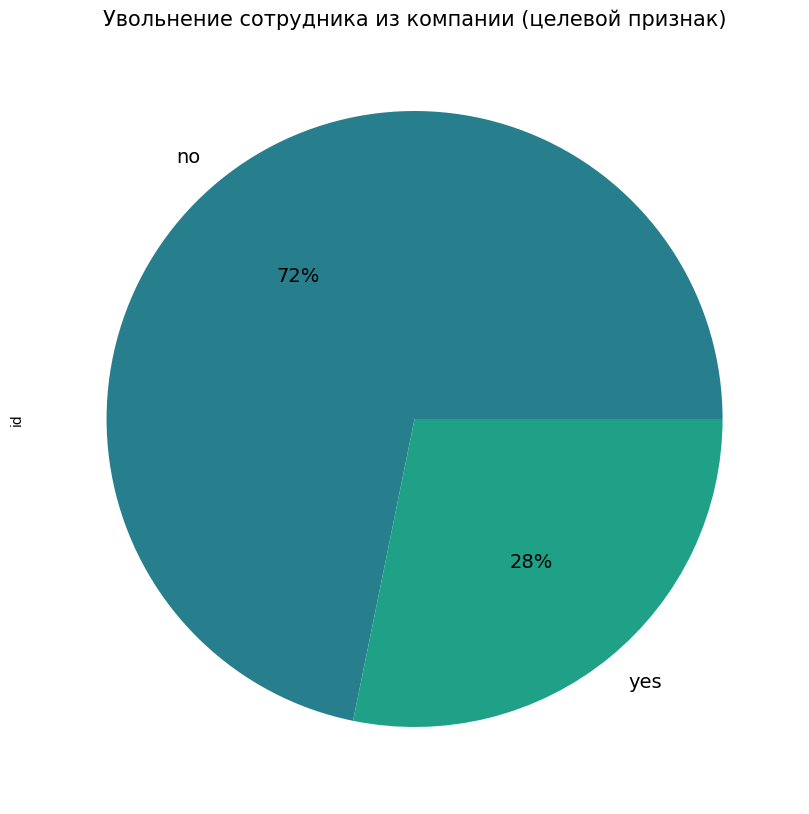

In [67]:
my_pie_plot(train_quit_df, 'quit', title='Увольнение сотрудника из компании (целевой признак)')

28% сотрудников уволились из компании.

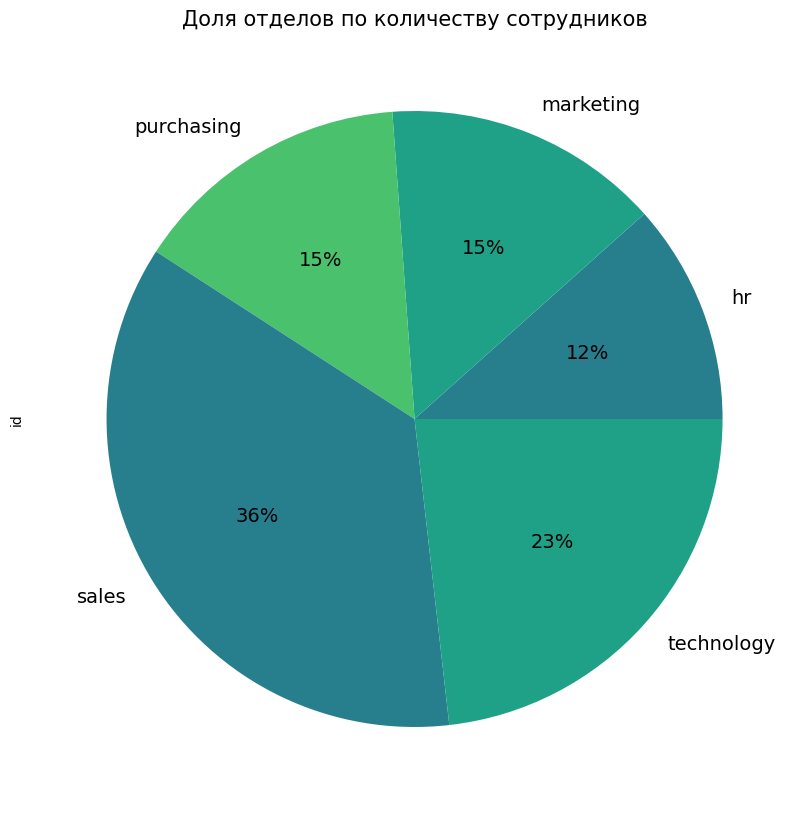

In [68]:
my_pie_plot(train_quit_df, 'dept', title='Доля отделов по количеству сотрудников')

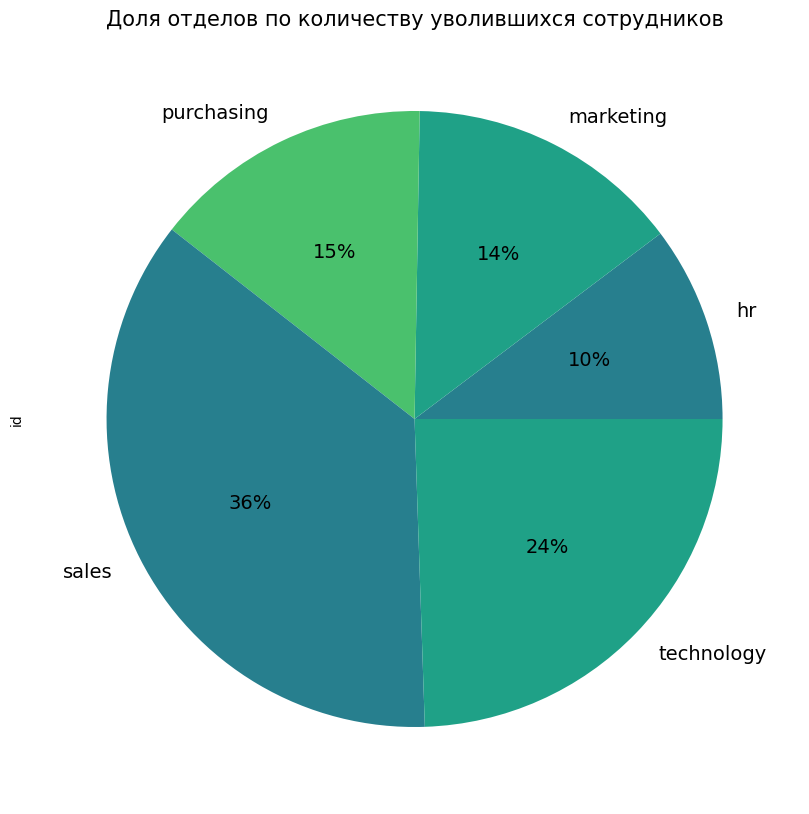

In [69]:
my_pie_plot(train_quit_df.query('quit == "yes"'), 'dept', title='Доля отделов по количеству уволившихся сотрудников')

Рзница распределения долей между общими данными и данными сотрудиков которые уволились не значительна - это значит, что увольнения происходят равномерно по отделам.

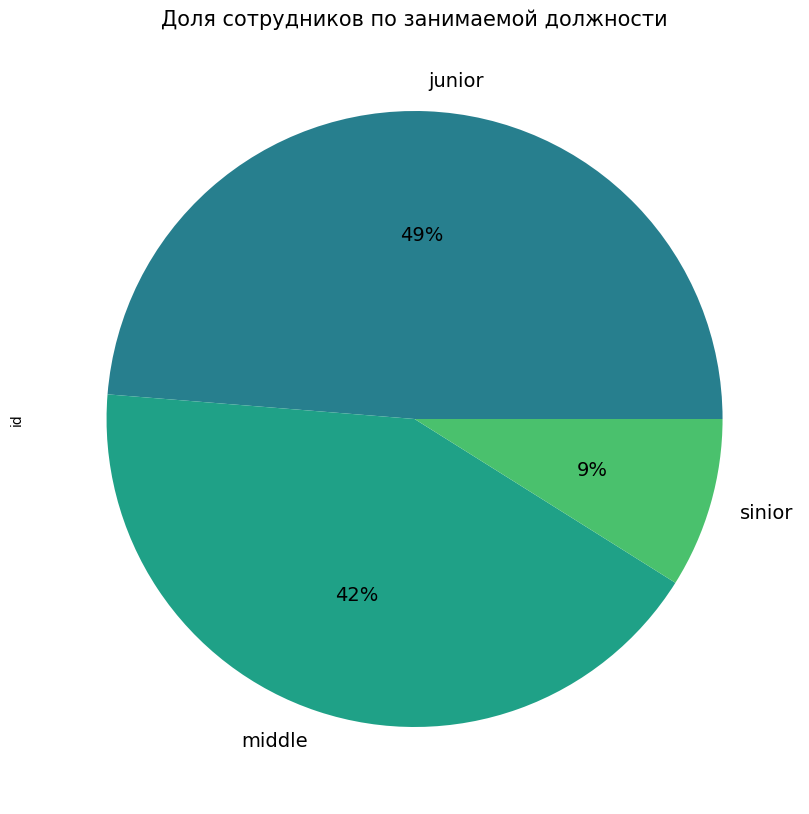

In [70]:
my_pie_plot(train_quit_df, 'level', title='Доля сотрудников по занимаемой должности')

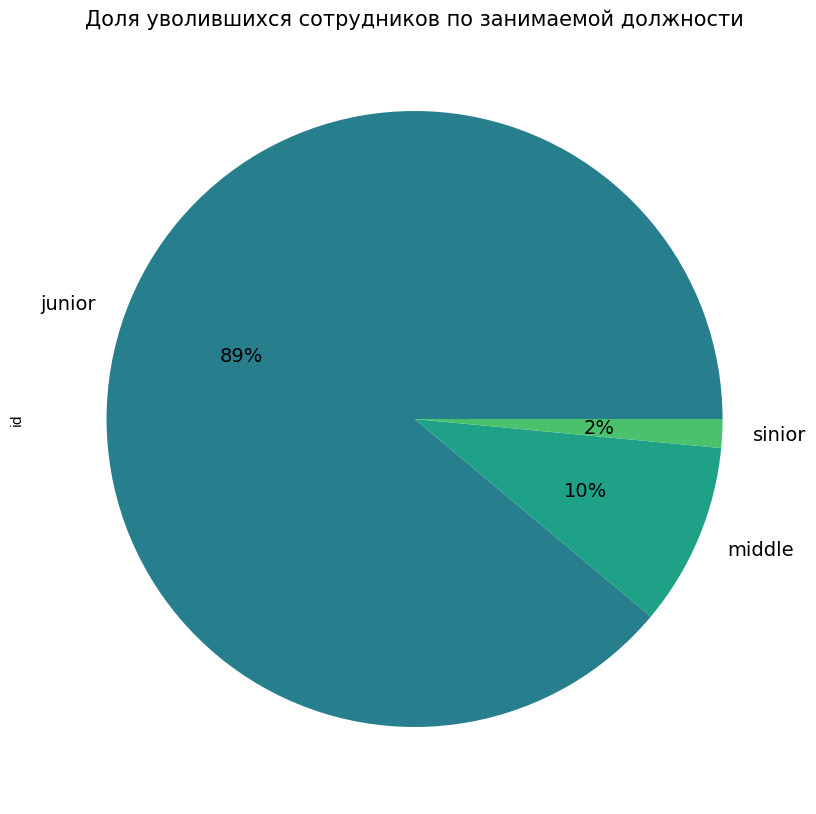

In [71]:
my_pie_plot(train_quit_df.query('quit == "yes"'), 'level', title='Доля уволившихся сотрудников по занимаемой должности')

Почти половина всех сотрудников компании это джуниоры, однако их доля среди всех уволившихся сотрудников 89%. Доля мидлов - 10%, синьоров - всего 2%.

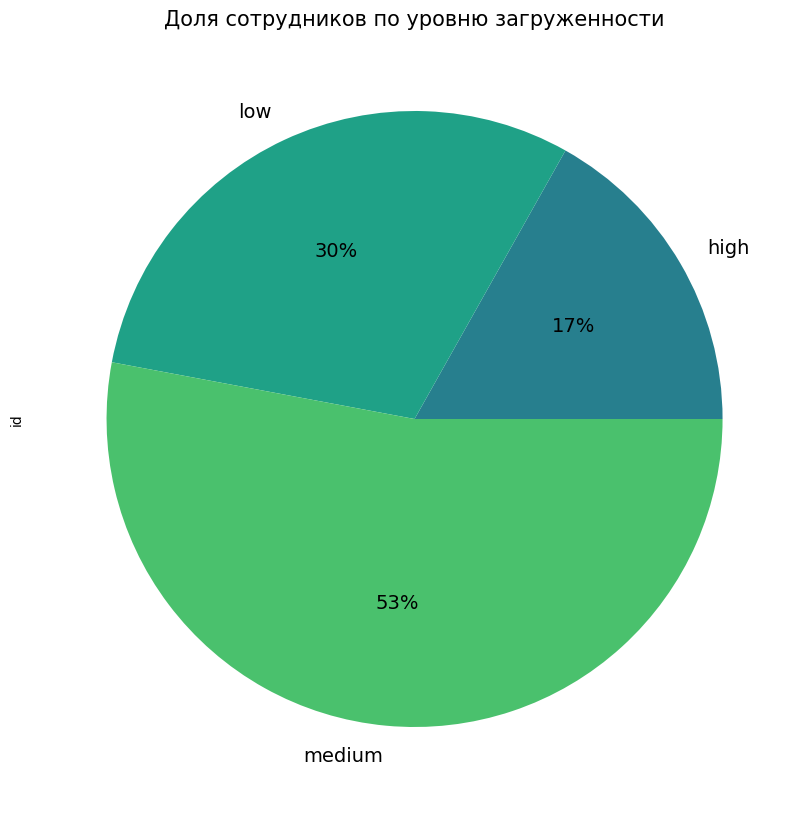

In [72]:
my_pie_plot(train_quit_df, 'workload', title='Доля сотрудников по уровню загруженности')

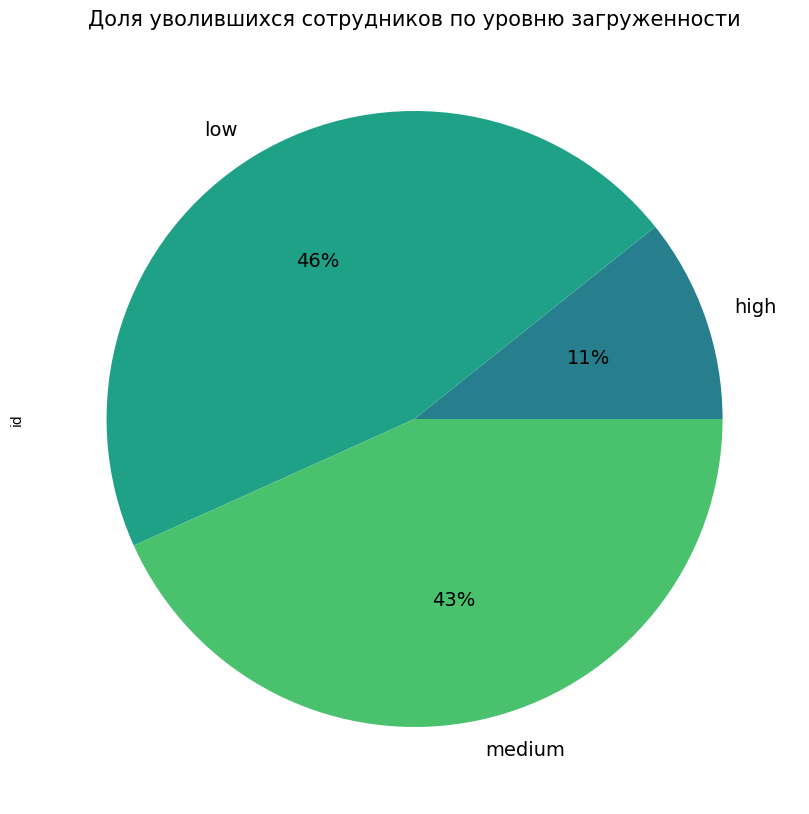

In [73]:
my_pie_plot(train_quit_df.query('quit == "yes"'), 'workload', title='Доля уволившихся сотрудников по уровню загруженности')

Доля слабозагруженных сотрудников в общей выборке 30%, однако они составляют почти половину из всех уволившихся работников.

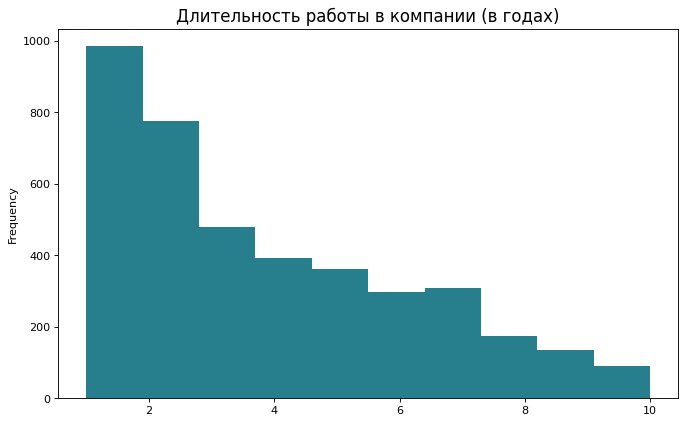

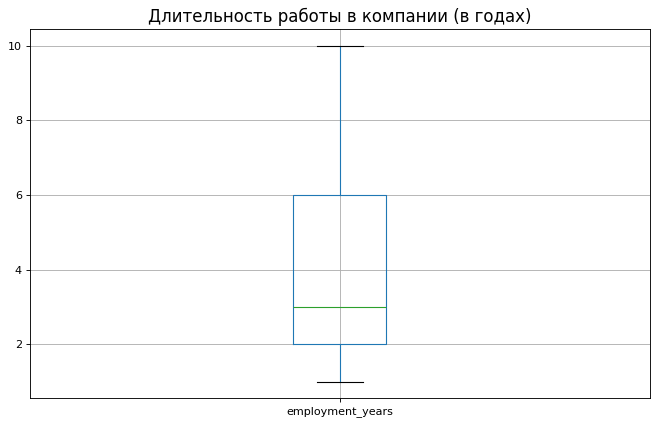

count    4000.000000
mean        3.701500
std         2.541852
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

In [74]:
my_plot(train_quit_df, 'employment_years', bins=10, title='Длительность работы в компании (в годах)')

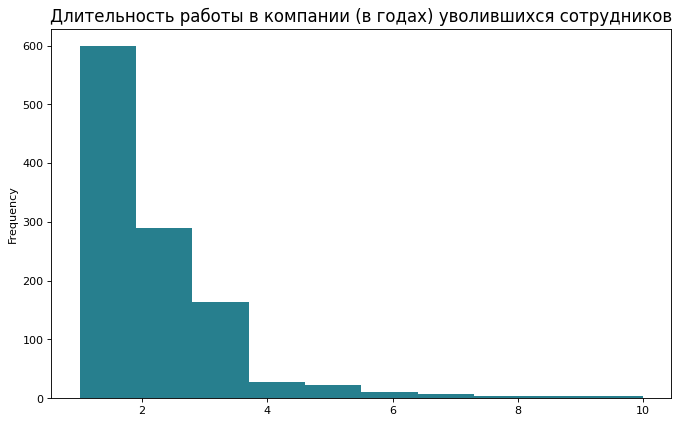

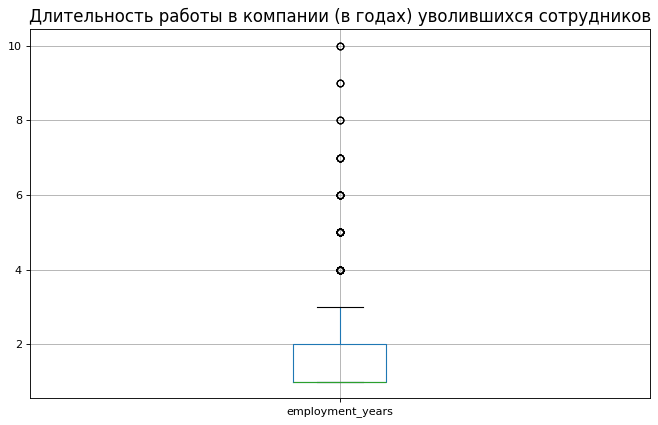

count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64

In [75]:
my_plot(
    train_quit_df.query('quit == "yes"'), 
    'employment_years', 
    bins=10, 
    title='Длительность работы в компании (в годах) уволившихся сотрудников'
)

Больше половины уволившихся сотрудников проработали в компании менее двух лет, средний срок работы уволившихся сотрудников примерно 1 год 10 месяцев.

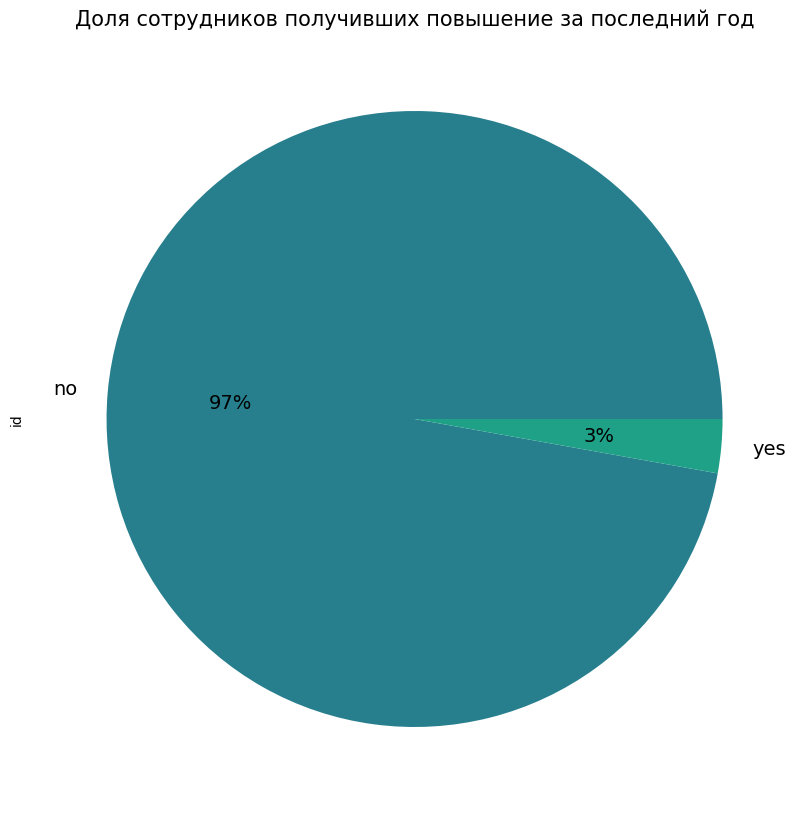

In [76]:
my_pie_plot(train_quit_df, 'last_year_promo', title='Доля сотрудников получивших повышение за последний год')

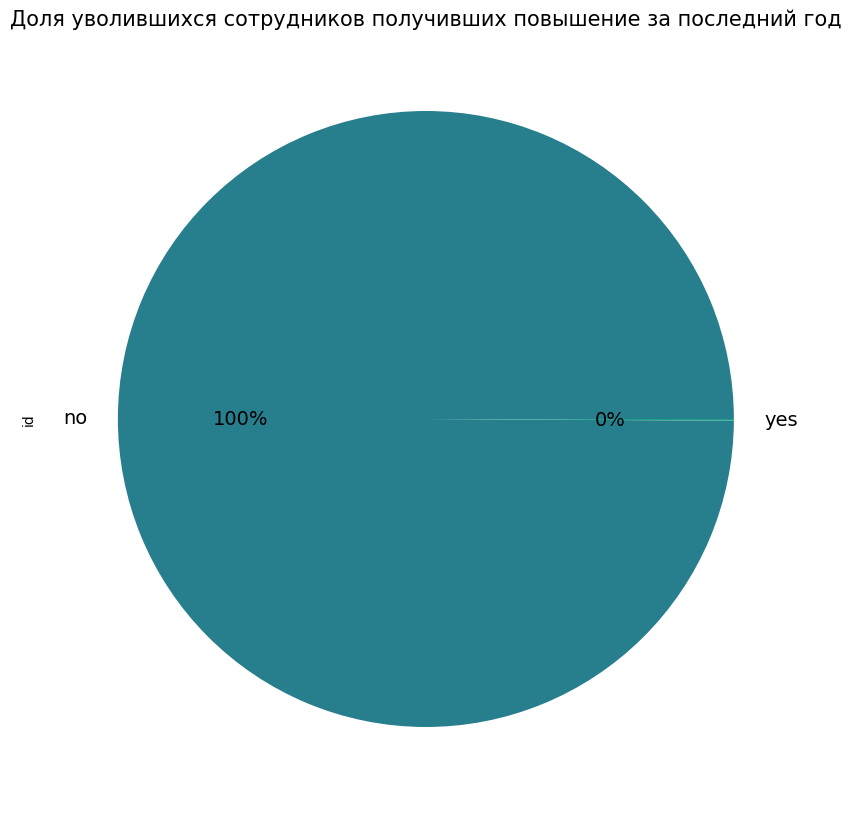

In [77]:
my_pie_plot(
    train_quit_df.query('quit == "yes"'), 
    'last_year_promo', 
    title='Доля уволившихся сотрудников получивших повышение за последний год'
)

Все 100% уволившихся сотрудников не получали повышение за последний год - это говорит о том, что повышение гарантирует сохранение сотрудника в компании.

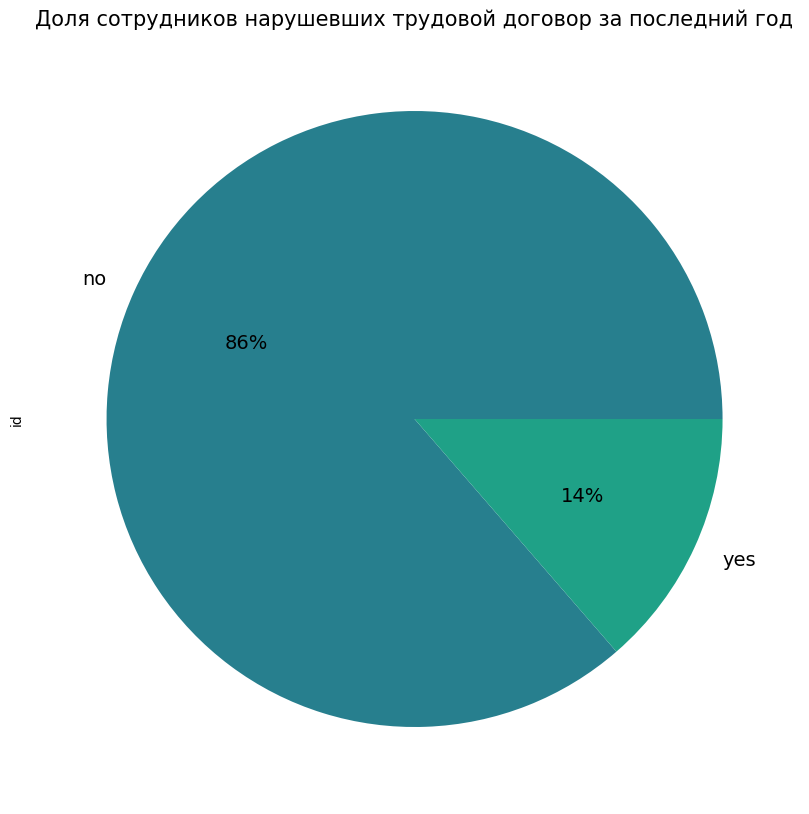

In [78]:
my_pie_plot(train_quit_df, 'last_year_violations', title='Доля сотрудников нарушевших трудовой договор за последний год')

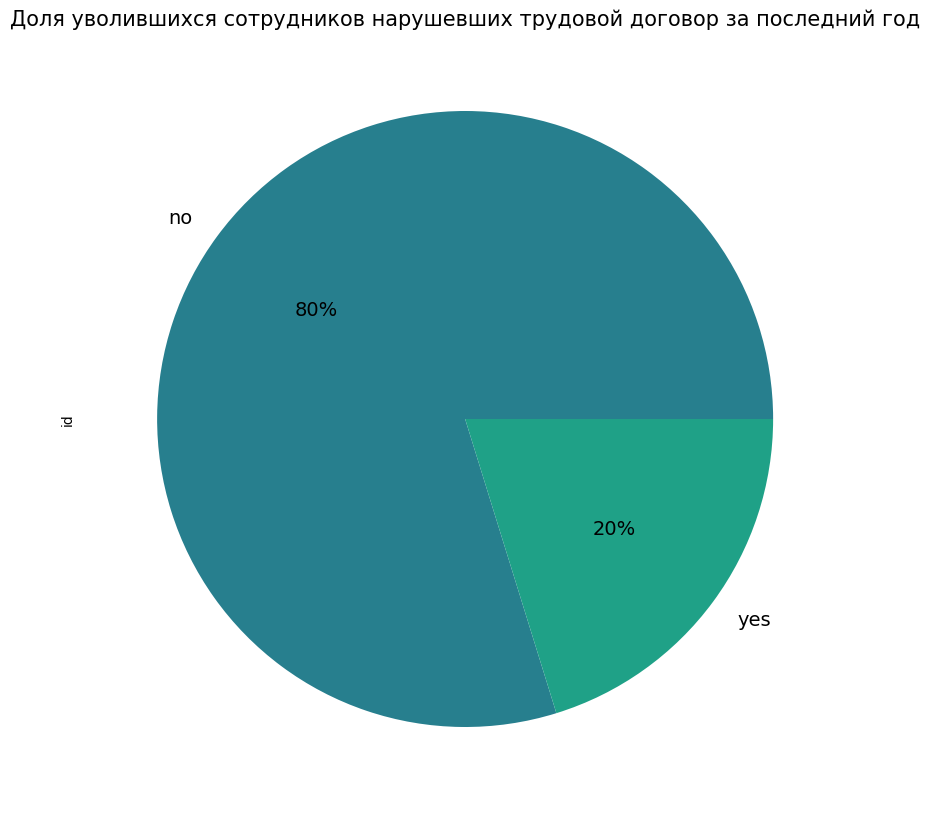

In [79]:
my_pie_plot(
    train_quit_df.query('quit == "yes"'), 
    'last_year_violations', 
    title='Доля уволившихся сотрудников нарушевших трудовой договор за последний год'
)

Уволенные сотрудники чаще нарушали трудовой договор, в 20% случаев вместо 14%. 

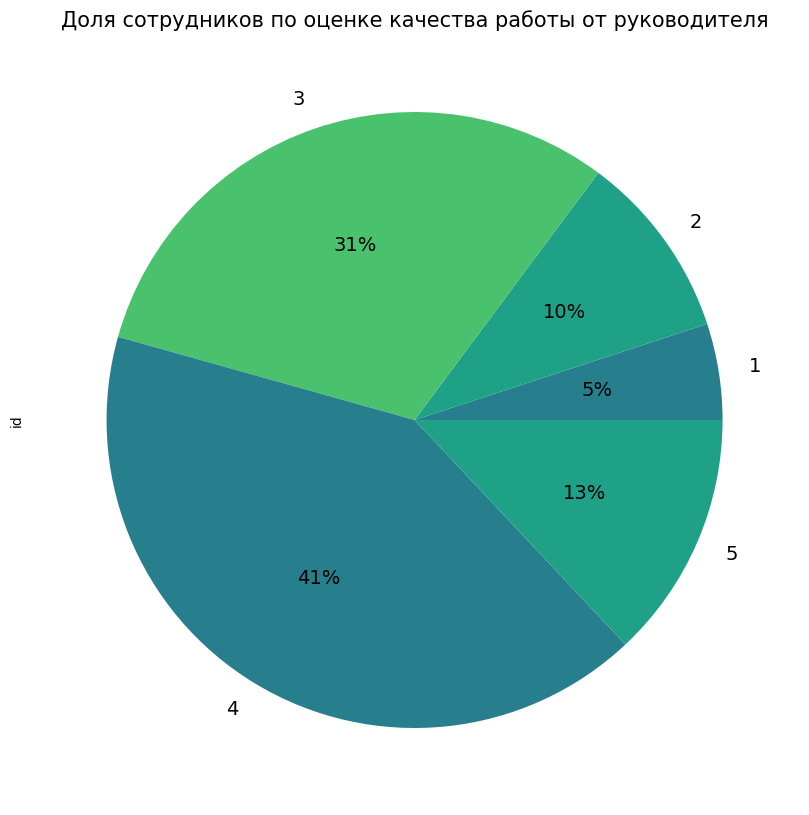

count    3752.000000
mean        3.463220
std         1.026304
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [80]:
my_pie_plot(train_quit_df, 'supervisor_evaluation', title='Доля сотрудников по оценке качества работы от руководителя')
train_df['supervisor_evaluation'].describe()

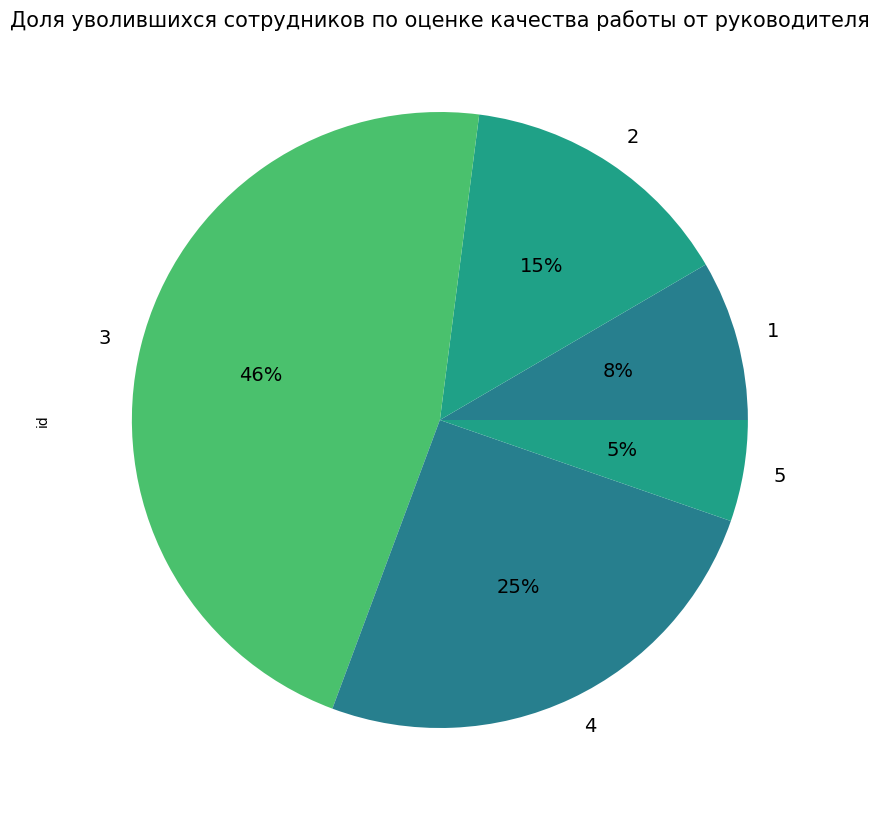

count    3752.000000
mean        3.463220
std         1.026304
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [81]:
my_pie_plot(
    train_quit_df.query('quit == "yes"'), 
    'supervisor_evaluation', 
    title='Доля уволившихся сотрудников по оценке качества работы от руководителя'
)
train_df['supervisor_evaluation'].describe()

Доля работников с оценкой руководителя 3, составляет 31% от общей выборки, однако от выборки с уволившимися сотрудниками они составляют уже около половины - 46%. 25% уволившихся имеют оценку 4, 15% оценку 2, 8% - 1, 5% - 5.

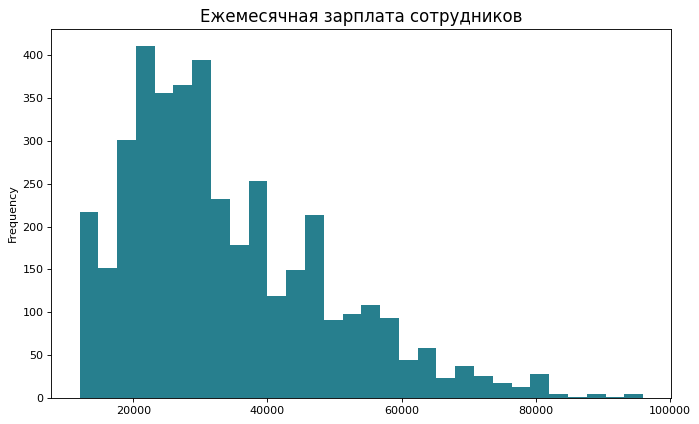

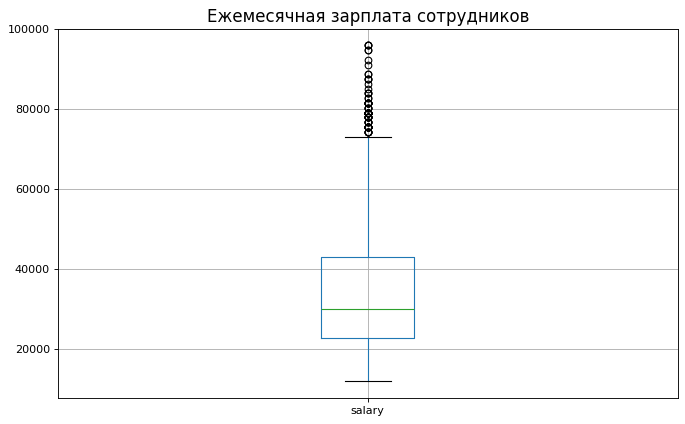

count     4000.000000
mean     33805.800000
std      15152.415163
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [82]:
my_plot(train_quit_df, 'salary', bins=30, title='Ежемесячная зарплата сотрудников')

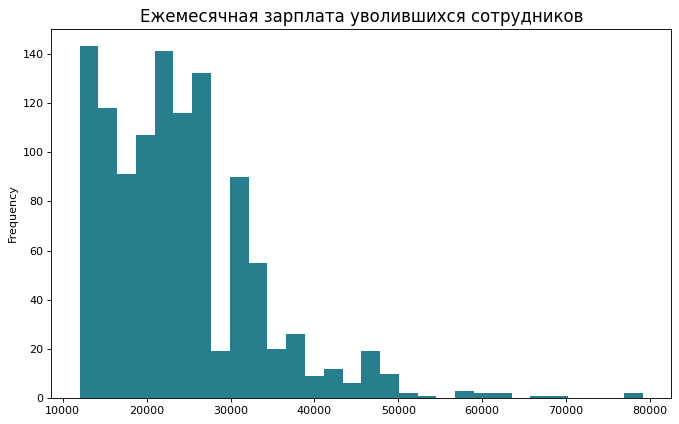

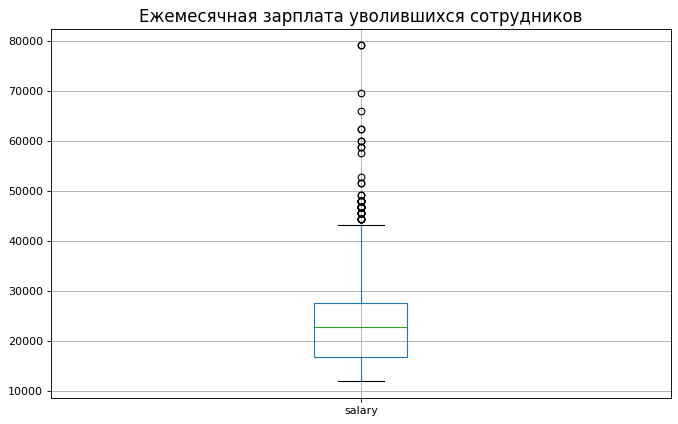

count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

In [83]:
my_plot(train_quit_df.query('quit == "yes"'), 'salary', bins=30, title='Ежемесячная зарплата уволившихся сотрудников')

Медианная зарплата уволившихся сотрудников почти на 30% меньше чем медианная зарплата у всех сотрудников, 22800 против 30000. Среди сотрудников которые решили уволиться, лишь единицы получали зарплату больше 45 тысяч рублей.

Все данные датасета *train_quit_df* распределены схоже с *train_df*, все отличия в рамках погрешности.

#### Исследовательский анализ целевого признака тестовой выборки

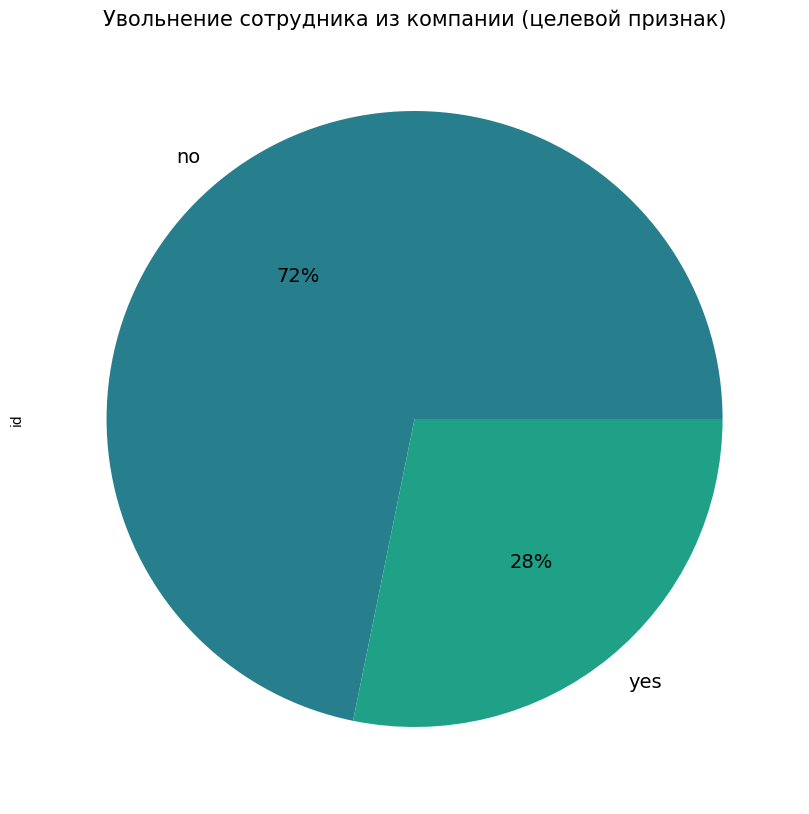

In [84]:
my_pie_plot(test_target_quit_df, 'quit', title='Увольнение сотрудника из компании (целевой признак)')

Соотношение данных целевого признака в *test_target_quit_df* и *train_quit_df* совпадают.

#### Влияние уровня удовлетворённости сотрудника работой в компании на его увольнение

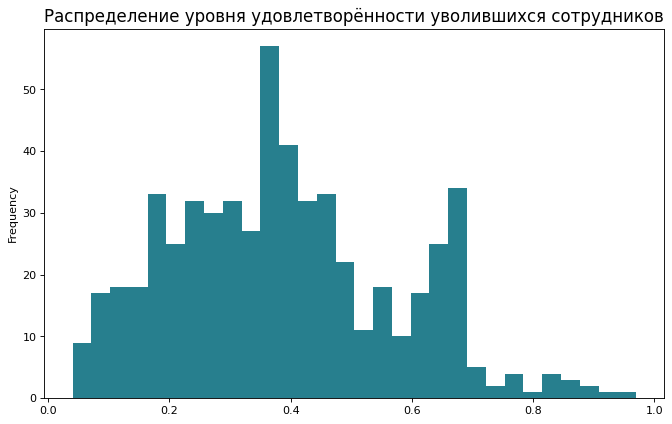

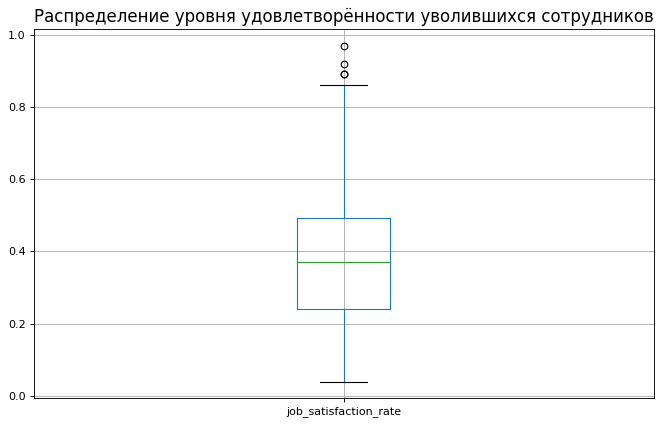

count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64

In [85]:
my_plot(
    test_target_df.join(test_target_quit_df.set_index('id')).query('quit == "yes"'), 
    'job_satisfaction_rate',
    bins=30,
    title='Распределение уровня удовлетворённости уволившихся сотрудников'
)

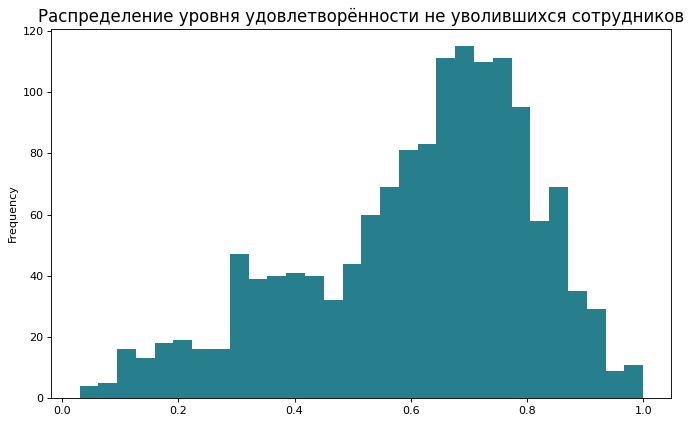

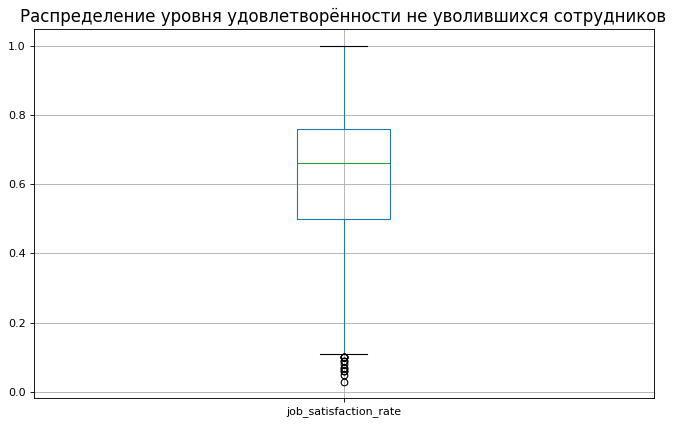

count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [86]:
my_plot(
    test_target_df.join(test_target_quit_df.set_index('id')).query('quit == "no"'), 
    'job_satisfaction_rate',
    bins=30,
    title='Распределение уровня удовлетворённости не уволившихся сотрудников'
)

Как виндно выше, распределения по уровню удовлетворённости уволившихся и не уволившихся сотрудников сильно отличается. У первых оно смещено влево, что говорит о том, что их удовлетворенность заметно ниже чем у вторых, чье распределение смещено вправо. У уволившихся средний уровень удовлетворенности работой 38%, а у не уволившихся 61%. Среди уволившихся нет ни одного, кто был бы удовлетварен работой на 100%.

#### Корреляционный анализ

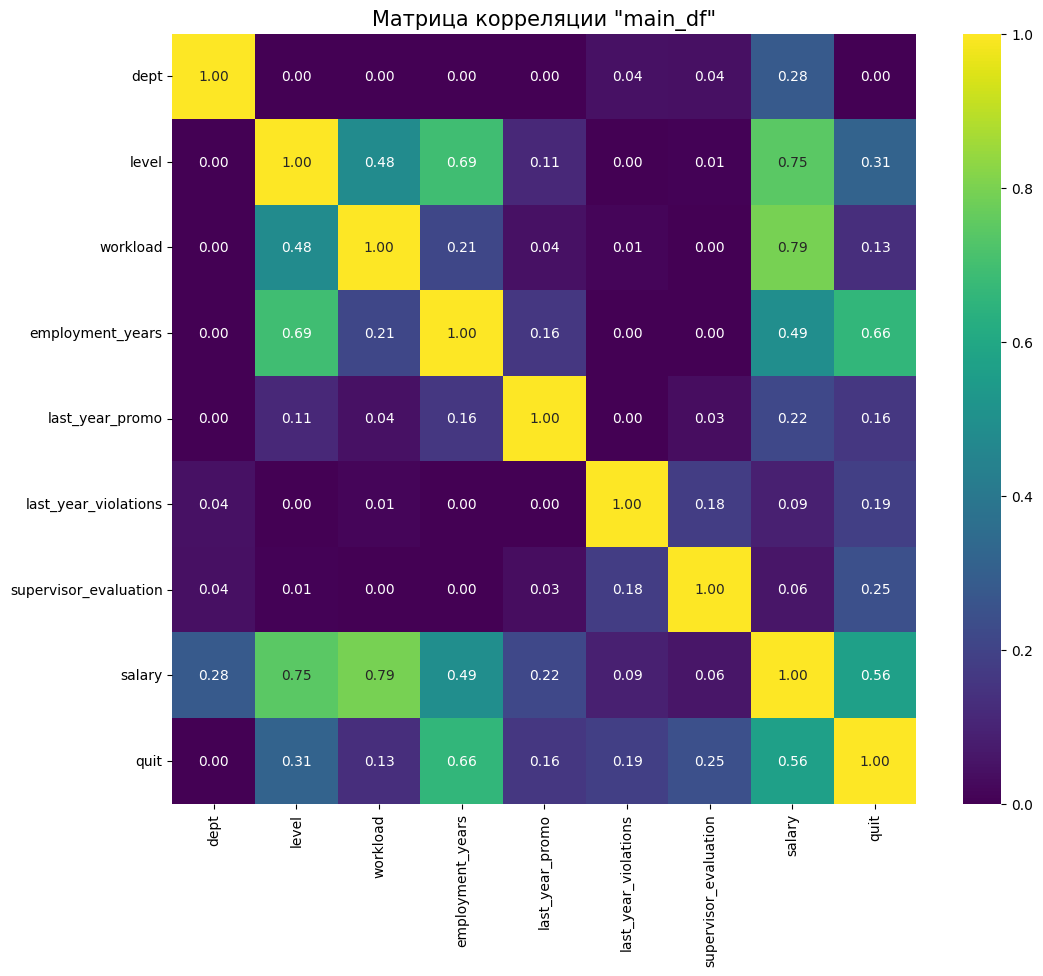

In [87]:
plt.figure(figsize=(12,10), dpi= 100)
sns.heatmap(train_quit_df.drop('id', axis=1).phik_matrix(interval_cols=['salary', 'job_satisfaction_rate']), annot = True, fmt=".2f", cmap='viridis')
plt.title('Матрица корреляции "main_df"',  fontdict = {'fontsize' : 15})
plt.show()

Мультиколениарность признаков не наблюдается. Целевой признак "quit" сильнее всего коррелирует с признаком "employment_years" - 0,66, так же заметно коррелирует с "salary" - 0,56 и умеренно с "level" - 0,31. Не коррелирует с "dept", имеет слабую корреляцию с "workload", "last_year_promo", "last_year_violations" и "supervisor_evaluation".

#### Вывод

Данные нового датасета *train_quit_df* по своему распределению сопоставимы с данными датасета *train_df*, явные отличия и аномалии отсутствуют. По данным целевого признака видно, что около четверти сотрудников уволились из компании. 

***Портрет усредненного уволившегося сотрудника:***
- Работает в отделе продаж
- Занимает должность джуниора
- Слабо загружен работой
- Проработал в компании менее двух лет
- В течении последнего года не получал повышения
- В течении последнего года не нарушал трудовой договор
- Имеет оценку качества работы от руководителя - 3
- Получал около 23 тысяч рублей в месяц

Уровень удовлетворенности работой сильно влияет на решение уволиться. У уволившихся средний уровень удовлетворенности равен 38%, а у не уволившихся 61%.

### Шаг 4. Добавление нового входного признака

Заменим индексы на значение признака "id" и отсортируем данные по индексу:

In [88]:
train_quit_df = train_quit_df.set_index('id').sort_values(by='id')
test_target_quit_df = test_target_quit_df.set_index('id').sort_values(by='id')

Проверим на наличие новых явных дубликатов:

In [89]:
train_quit_df.duplicated().sum()

np.int64(1413)

Удалим дубликаты в train_quit_df:

In [90]:
train_quit_df.shape

(4000, 9)

In [91]:
train_quit_df.drop_duplicates(keep='first', inplace=True)

In [92]:
train_quit_df.shape

(2587, 9)

Добавим job_satisfaction_rate, предсказанный итоговой моделью из первой задачи, к *train_quit_df*  и к *test_df*:

In [93]:
X_train_quit_df = train_quit_df.drop('quit', axis=1)
X_test_df = test_df.copy(deep=True)

In [94]:
X_train_quit_df['salary_bin'] = X_train_quit_df['salary'].apply(bin_salary)
X_test_df['salary_bin'] = X_test_df['salary'].apply(bin_salary)

In [95]:
train_quit_df['job_satisfaction_rate'] = jsr_model.predict(X_train_quit_df)

In [96]:
train_quit_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
100222,sales,junior,medium,3,no,no,2,20400,yes,0.345714
100459,purchasing,junior,medium,3,no,no,3,21600,yes,0.311667
100469,marketing,junior,medium,1,no,no,4,28800,no,0.648182
100601,technology,middle,high,4,no,no,4,68400,no,0.677500
100858,sales,junior,medium,2,no,no,4,25200,yes,0.847143


In [97]:
train_quit_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2587 entries, 100222 to 999915
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2587 non-null   object 
 1   level                  2587 non-null   object 
 2   workload               2587 non-null   object 
 3   employment_years       2587 non-null   int64  
 4   last_year_promo        2587 non-null   object 
 5   last_year_violations   2587 non-null   object 
 6   supervisor_evaluation  2587 non-null   int64  
 7   salary                 2587 non-null   int64  
 8   quit                   2587 non-null   object 
 9   job_satisfaction_rate  2587 non-null   float64
dtypes: float64(1), int64(3), object(6)
memory usage: 222.3+ KB


In [98]:
test_df['job_satisfaction_rate'] = jsr_model.predict(X_test_df)

In [99]:
test_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.835625
100480,marketing,junior,low,4,no,no,4,16800,0.852000
100503,purchasing,middle,high,5,no,no,4,55200,0.754167
100610,sales,middle,medium,5,no,no,4,43200,0.816667
100692,sales,middle,high,6,no,no,4,48000,0.702500


In [100]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100298 to 999029
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   2000 non-null   object 
 1   level                  2000 non-null   object 
 2   workload               2000 non-null   object 
 3   employment_years       2000 non-null   int64  
 4   last_year_promo        2000 non-null   object 
 5   last_year_violations   2000 non-null   object 
 6   supervisor_evaluation  2000 non-null   int64  
 7   salary                 2000 non-null   int64  
 8   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 156.2+ KB


### Шаг 5. Подготовка данных

Создадим кодировщик для целевого признака через OrdinalEncoder:

In [101]:
y_ord = OrdinalEncoder(categories=[['no', 'yes']])

Закодируем данные:

In [102]:
# Списки с наименованиями кодируемых признаков
ohe_col = ['dept', 'last_year_promo', 'last_year_violations']
ord_col = ['level', 'workload']
num_col = ['salary', 'job_satisfaction_rate']

# Пайплайн для OneHotEncoder кодирования
ohe_pipe = Pipeline([
    ('ohe_encoder', OneHotEncoder(drop='first', handle_unknown='error'))
])

# Пайплайн для OrdinalEncoder кодирования
ord_pipe = Pipeline([
    ('ord_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
]) 

# Общий пайплайн для кодирования всех признаков
data_prerocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_col),
    ('ord', ord_pipe, ord_col),
    ('num', StandardScaler(), num_col)
],
    remainder='passthrough'
)

Сформируем датасеты *train* и *test*:

In [103]:
X_train = data_prerocessor.fit_transform(train_quit_df.drop('quit', axis=1))
y_train = y_ord.fit_transform(pd.DataFrame(train_quit_df['quit'])).ravel()

X_test = data_prerocessor.transform(test_df)
y_test = y_ord.transform(test_target_quit_df)

### Шаг 6. Обучение модели

Создадим пайплайн для подбора модели и гиперпараметров:

In [104]:
pipe_second_model = Pipeline(
    [
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

param_grid = [
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10)
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__max_features': range(1, 10),
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability= True)],
        'models__degree': range(1, 10),
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 5),
    },
]

randomized_search = RandomizedSearchCV(
    pipe_second_model,
    param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=RANDOM_STATE
)


randomized_search.fit(X_train, y_train)

print('Лучшая модель:', randomized_search.best_estimator_)
print('Метрика лучшей модели на тренировочных данных:', randomized_search.best_score_)

Лучшая модель: Pipeline(steps=[('models',
                 LogisticRegression(C=1, penalty='l1', random_state=42,
                                    solver='liblinear'))])
Метрика лучшей модели на тренировочных данных: 0.9104905033164117


In [105]:
result = pd.DataFrame(randomized_search.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
9,1,"LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",0.910491,"{'models__C': 1, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
6,2,"SVC(kernel='poly', probability=True, random_state=42)",0.909368,"{'models__degree': 1, 'models': SVC(kernel='poly', probability=True, random_state=42)}"
4,3,DecisionTreeClassifier(random_state=42),0.899213,"{'models__max_features': 7, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
5,4,DecisionTreeClassifier(random_state=42),0.894542,"{'models__max_features': 5, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
2,5,DecisionTreeClassifier(random_state=42),0.894035,"{'models__max_features': 9, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
1,6,DecisionTreeClassifier(random_state=42),0.876712,"{'models__max_features': 5, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
3,7,DecisionTreeClassifier(random_state=42),0.862398,"{'models__max_features': 3, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
0,8,DecisionTreeClassifier(random_state=42),0.834702,"{'models__max_features': 4, 'models__max_depth': 3, 'models': DecisionTreeClassifier(random_state=42)}"
7,9,DecisionTreeClassifier(random_state=42),0.808759,"{'models__max_features': 1, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
8,10,DecisionTreeClassifier(random_state=42),0.527702,"{'models__max_features': 2, 'models__max_depth': 1, 'models': DecisionTreeClassifier(random_state=42)}"


In [106]:
proba = randomized_search.predict_proba(X_test)
proba = proba[:, 1]

print('Метрика лучшей модели на тестовых данных:', roc_auc_score(y_test, proba))

Метрика лучшей модели на тестовых данных: 0.9161363569015587


Метрика на тестовых данных получилась 0,916, что соответствует критерию успеха - не менее 0,91.

### Шаг 7. Выводы

В ходе подбора модели на кросс валидации, была выбрана модель **DecisionTreeClassifier(max_depth=4, max_features=7, random_state=42)**, метрика ROC_AUC на тестовых данных получилась 0,916. Для получения такой метрики потребовалось удалить из обучения модели признаки "supervisor_evaluation", "dept", "salary" и провести бининг признака "job_satisfaction_rate".

## Общий вывод

Было поставлено две задачи:
- Первая задача — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


Проведенные этапы работы:

Для решения первой задачи были получены 3 таблицы, была произведена обработка пропусков и дубликатов, проведен исследовательский анализ данных, создан пайплайн для подготовки данных к обучению модели, подобрана и обучена модель DecisionTreeRegressor, результат на тестовых данных по собственной метрике SMAPE равен 13,35 при при критерии успеха ниже или равным 15.

Для решения второй задачи были получены 2 новые таблицы, была произведена предобработка данных, проведен исследовательский анализ, добавление нового признака к входным признакам с помощью модели, обученной в первой задаче, подобрана и обучена модель LogisticRegression, результат на тестовых данных по метрике ROC-AUC равен 0,916 при при критерии успеха не ниже 0,91.

В ходе исследования было выявлено, что стоит обратить внимание на очень высокую текучку кадров середи тех кто проработал в компании менее двух лет, так как среди всех увольнений, их доля более 50%. Более 80% увольнений приходится на джуниоров.

Портрет «уволившегося сотрудника»:
- Работает в отделе продаж
- Занимает должность джуниора
- Слабо загружен работой
- Проработал в компании менее двух лет
- В течении последнего года не получал повышения
- В течении последнего года не нарушал трудовой договор
- Имеет оценку качества работы от руководителя - 3
- Получал около 23 тысяч рублей в месяц

Самым эффективным способом удержать сотрудника, является повышение, никто из тех кого повысили не уволился в течении года. За последний год всего лишь 3% сотрудников получили повышение. Так же чаще всего покидают компанию слабо загруженные работой сторудники, всего таких сотрудников в компании 30%, стоит рассмотреть возможность оптимизации штата или об оптимизации распределения задач между сотрудниками.